# Data Science case study: 311 service request modeling

Project using two data sets: 311 service requests and weather data from NY weather stations

### Final goal of project: predict the daily 311 inbound calls for the next 7 days 

•	Use your insights from previous sections to build a predictive model of your choice – explain the assumptions of your model and why you picked it.

•	What features are you using in your model and, how does your data exploration process help you decide which features you are incorporating in your model?

•	Evaluate the impact of weather on the call volume, find patterns and define causal impact if there’s any. 

•	Build a reasonable model framework, explain your model results, and justify the relationships identified in the model. Not necessary to dig into complex models.


### Previous work in 311_exploration and weather_exploration files

Grouped 311 calls by day to get a call count for each day.

Restricted weather data to NYC region and averaged data over the reporting weather stations for each day.

I can now import and combine these dataframes to model the 311 calls.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats

# for building linear regression models and preparing data
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
weather_path = 'weather_daily_avg.csv'
dfw = pd.read_csv(weather_path, parse_dates=['Date'])

In [3]:
daily_311_path = '311_daily_counts.csv'
d311 = pd.read_csv(daily_311_path, parse_dates=['Date'])

In [4]:
dfw

,Date,MeanTemp,MinTemp,MaxTemp,DewPoint,Percipitation,WindSpeed,MaxSustainedWind,Gust,SnowDepth
0,2016-01-01,41.280,38.380,48.080,25.800000,0.0240,6.000000,15.333333,24.666667,NaN
1,2016-01-02,36.820,33.420,41.920,18.466667,0.0000,6.140000,15.733333,22.433333,NaN
2,2016-01-03,38.800,33.180,45.920,21.333333,0.0000,5.680000,14.333333,23.066667,NaN
3,2016-01-04,32.540,21.620,42.640,15.066667,0.0000,7.060000,17.700000,27.366667,NaN
4,2016-01-05,18.900,11.820,34.320,-0.500000,0.0000,7.080000,20.400000,30.000000,NaN
...,...,...,...,...,...,...,...,...,...,...
1041,2018-11-07,57.700,50.225,63.500,45.800000,0.6875,10.833333,15.600000,29.733333,NaN
1042,2018-11-08,53.725,46.750,63.500,34.525000,0.0125,8.566667,14.666667,19.300000,NaN
1043,2018-11-09,47.775,42.250,56.325,36.125000,0.0000,9.800000,15.700000,20.000000,NaN
1044,2018-11-10,47.125,39.175,52.775,35.700000,0.7475,12.433333,22.733333,31.333333,NaN


In [5]:
d311

,Date,call_count
0,2016-01-01,4260.0
1,2016-01-02,4505.0
2,2016-01-03,4749.0
3,2016-01-04,8900.0
4,2016-01-05,11936.0
...,...,...
1091,2018-12-27,7019.0
1092,2018-12-28,6923.0
1093,2018-12-29,5153.0
1094,2018-12-30,5112.0


Weather data only goes through 2018-11-11. Restrict 311 call data to this region as well.

In [6]:
d311_r = d311.loc[d311['Date'] <np.datetime64('2018-11-12')]

In [7]:
d311_r

,Date,call_count
0,2016-01-01,4260.0
1,2016-01-02,4505.0
2,2016-01-03,4749.0
3,2016-01-04,8900.0
4,2016-01-05,11936.0
...,...,...
1041,2018-11-07,7926.0
1042,2018-11-08,8138.0
1043,2018-11-09,7468.0
1044,2018-11-10,6524.0


Combine dataframes. They have identical Date and index columns, so I can just add the call counts to the end of the weather dataframe.

In [8]:
dfw['call_count'] = d311_r['call_count']

In [9]:
# rename new dataframe with all data
df = dfw

Add a date_iter column. This column counts the number of days since 2016-01-01. It is useful as a model input to account for changes in 311 patterns over time (since I previously saw that call numbers increased over time)


In [10]:
df['date_iter'] = np.arange(len(df))

I found in my exploration that call numbers vary by day (and specifically are lower on weekends). Here I will add one-hot encoded variables for day of the week.

In [11]:
# Fist add a weekday column to the dataframe (0 represents a monday)
df['weekday'] = df['Date'].dt.dayofweek

In [12]:
df

,Date,MeanTemp,MinTemp,MaxTemp,DewPoint,Percipitation,WindSpeed,MaxSustainedWind,Gust,SnowDepth,call_count,date_iter,weekday
0,2016-01-01,41.280,38.380,48.080,25.800000,0.0240,6.000000,15.333333,24.666667,NaN,4260.0,0,4
1,2016-01-02,36.820,33.420,41.920,18.466667,0.0000,6.140000,15.733333,22.433333,NaN,4505.0,1,5
2,2016-01-03,38.800,33.180,45.920,21.333333,0.0000,5.680000,14.333333,23.066667,NaN,4749.0,2,6
3,2016-01-04,32.540,21.620,42.640,15.066667,0.0000,7.060000,17.700000,27.366667,NaN,8900.0,3,0
4,2016-01-05,18.900,11.820,34.320,-0.500000,0.0000,7.080000,20.400000,30.000000,NaN,11936.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,2018-11-07,57.700,50.225,63.500,45.800000,0.6875,10.833333,15.600000,29.733333,NaN,7926.0,1041,2
1042,2018-11-08,53.725,46.750,63.500,34.525000,0.0125,8.566667,14.666667,19.300000,NaN,8138.0,1042,3
1043,2018-11-09,47.775,42.250,56.325,36.125000,0.0000,9.800000,15.700000,20.000000,NaN,7468.0,1043,4
1044,2018-11-10,47.125,39.175,52.775,35.700000,0.7475,12.433333,22.733333,31.333333,NaN,6524.0,1044,5


In [13]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse_output=False)
df.loc[:,'weekday'].to_numpy().reshape((-1,1))
weekday_oh_array = enc.fit_transform(df.loc[:,'weekday'].to_numpy().reshape((-1,1)))

Note: should potentially drop one of the day columns when fitting the model to avoid multicolinearity (dummy variable trap).

In [14]:
weekday_df = pd.DataFrame(weekday_oh_array, columns=['MO', 'TU', 'WE', 'TH', 'FR', 'SA', 'SU'])

In [15]:
weekday_df

,MO,TU,WE,TH,FR,SA,SU
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1041,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1042,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1043,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1044,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
# Add one-hot weekday_df to df
df.loc[:,['MO', 'TU', 'WE', 'TH', 'FR', 'SA', 'SU']] = weekday_df

### Look at cross correlations
This should give some insights as to which variables might be useful to include in a model.

In [17]:
df.corr(numeric_only=True)

,MeanTemp,MinTemp,MaxTemp,DewPoint,Percipitation,WindSpeed,MaxSustainedWind,Gust,SnowDepth,call_count,date_iter,weekday,MO,TU,WE,TH,FR,SA,SU
MeanTemp,1.000000,0.986413,0.984203,0.945329,-0.023890,-0.272226,-0.362162,-0.158786,-0.190153,-0.032157,1.558039e-01,-0.011653,-0.018574,0.003104,0.026576,0.023584,0.002156,-1.870773e-02,-0.018041
MinTemp,0.986413,1.000000,0.959024,0.949214,-0.014902,-0.259499,-0.361449,-0.162022,-0.219496,-0.047762,1.474959e-01,-0.007776,-0.018633,-0.000343,0.022387,0.022475,0.009958,-1.887725e-02,-0.016896
MaxTemp,0.984203,0.959024,1.000000,0.914745,-0.031329,-0.260779,-0.345119,-0.146957,-0.220529,-0.021437,1.650278e-01,-0.009144,-0.017028,-0.005334,0.032487,0.023564,-0.000522,-1.836695e-02,-0.014706
DewPoint,0.945329,0.949214,0.914745,1.000000,0.001336,-0.268946,-0.356734,-0.143718,-0.131620,-0.035583,2.118634e-01,-0.024618,-0.018019,0.020975,0.032195,0.011779,-0.001231,-1.745813e-02,-0.028110
Percipitation,-0.023890,-0.014902,-0.031329,0.001336,1.000000,0.115214,0.132010,0.101133,-0.004878,0.039702,4.620774e-03,-0.050725,-0.028974,0.114126,-0.018143,0.019425,-0.033334,-2.523169e-02,-0.027627
WindSpeed,-0.272226,-0.259499,-0.260779,-0.268946,0.115214,1.000000,0.779153,0.395667,0.140872,0.220579,2.347602e-01,0.012017,0.004187,-0.004364,-0.042144,0.003896,0.033511,1.754363e-02,-0.012737
MaxSustainedWind,-0.362162,-0.361449,-0.345119,-0.356734,0.132010,0.779153,1.000000,0.554885,0.120827,0.084261,-1.111375e-01,-0.000426,-0.007148,0.015522,-0.027999,0.007315,0.022869,1.186668e-02,-0.022459
Gust,-0.158786,-0.162022,-0.146957,-0.143718,0.101133,0.395667,0.554885,1.000000,0.179922,0.164496,3.716407e-03,-0.071490,-0.022692,0.077685,0.022407,0.062196,-0.024753,-6.476723e-02,-0.048634
SnowDepth,-0.190153,-0.219496,-0.220529,-0.131620,-0.004878,0.140872,0.120827,0.179922,1.000000,0.061168,-2.440670e-01,0.056595,-0.017578,-0.033071,-0.031168,0.034116,-0.059305,8.219260e-02,0.022439
call_count,-0.032157,-0.047762,-0.021437,-0.035583,0.039702,0.220579,0.084261,0.164496,0.061168,1.000000,3.402758e-01,-0.566322,0.181017,0.236354,0.187236,0.149307,0.069246,-3.611690e-01,-0.459893


We can see a number of things from looking at thes correlations.

a) There are a number of strongly colinear variables (such as MeanTemp and MinTemp). I may want to skip the highly colinear variables in modeling to improve interpretability.

b) Weekends are strongly anticorrelated with call_count (as expected from earlier analysis).

c) date_iter (time) is correlated with call_count (as expected from earlier analyis).

d) Temperature is correlated with call_count, though maybe not incredibly strongly.

I can analyze some of this by plotting the correlations.

Very low temperatures tend to result in very high call counts.

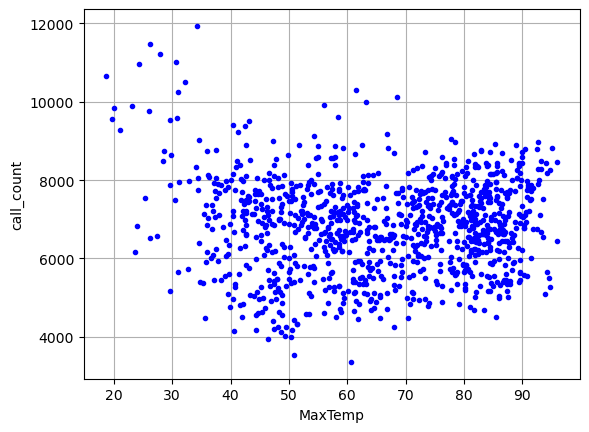

In [18]:
fig, ax = plt.subplots()
ax.plot(df['MaxTemp'], df['call_count'], '.', color = 'b')
ax.grid(True)
ax.set_ylabel(r'call_count')
ax.set_xlabel(r'MaxTemp')
plt.show()

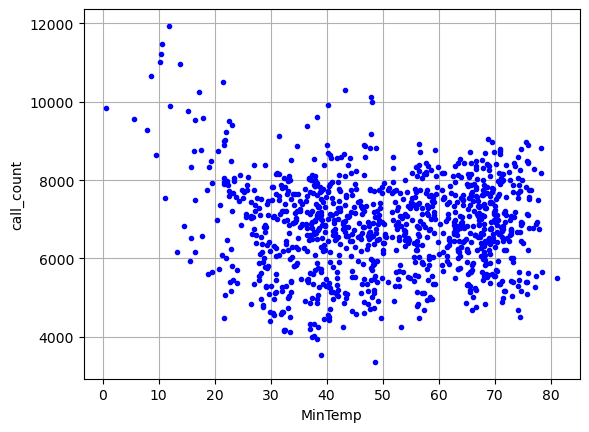

In [19]:
fig, ax = plt.subplots()
ax.plot(df['MinTemp'], df['call_count'], '.', color = 'b')
ax.grid(True)
ax.set_ylabel(r'call_count')
ax.set_xlabel(r'MinTemp')
plt.show()

Precipitation is weakly correlated with call_counts. Extremely high precipitation values don't result in big call_counts.

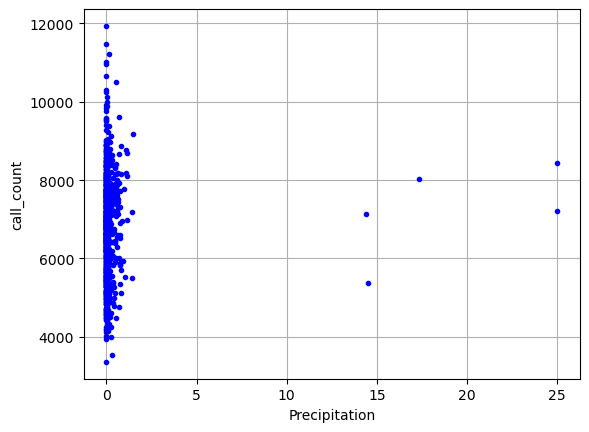

In [20]:
fig, ax = plt.subplots()
ax.plot(df['Percipitation'], df['call_count'], '.', color = 'b')
ax.grid(True)
ax.set_ylabel(r'call_count')
ax.set_xlabel(r'Precipitation')
plt.show()

DewPoint seems to basically track with temperature. Calls do not appear to increase hugely with higher dew points (which would be related to high humidity).

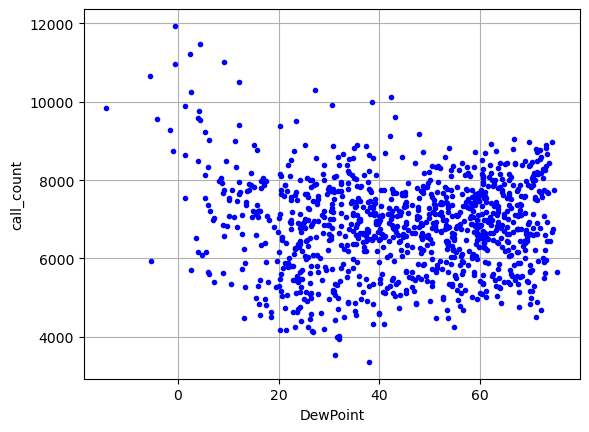

In [21]:
fig, ax = plt.subplots()
ax.plot(df['DewPoint'], df['call_count'], '.', color = 'b')
ax.grid(True)
ax.set_ylabel(r'call_count')
ax.set_xlabel(r'DewPoint')
plt.show()

Gust is somewhat weakly correlated with call counts. It is reasonable as a variable to include.

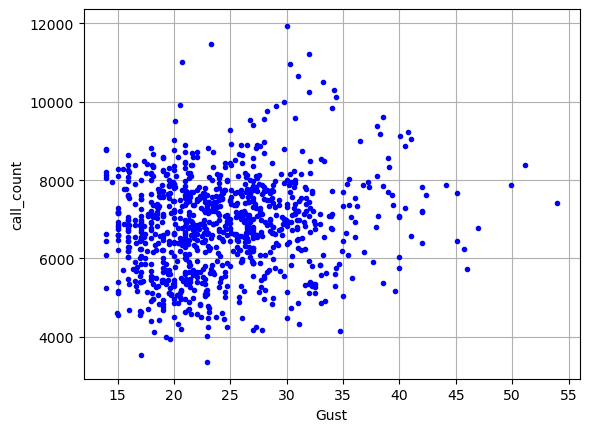

In [22]:
fig, ax = plt.subplots()
ax.plot(df['Gust'], df['call_count'], '.', color = 'b')
ax.grid(True)
ax.set_ylabel(r'call_count')
ax.set_xlabel(r'Gust')
plt.show()

WindSpeed is somewhat weakly correlated with call counts. It is reasonable as a variable to include.

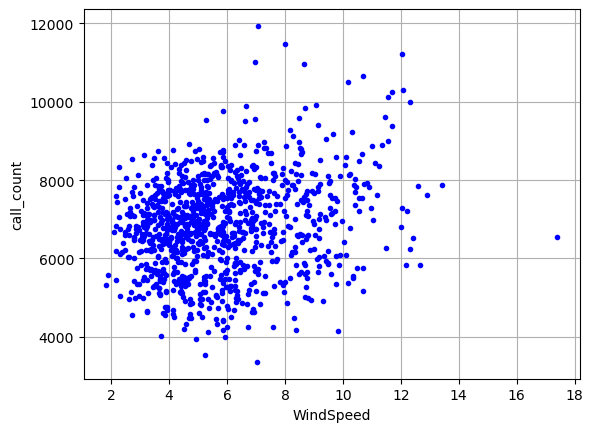

In [23]:
fig, ax = plt.subplots()
ax.plot(df['WindSpeed'], df['call_count'], '.', color = 'b')
ax.grid(True)
ax.set_ylabel(r'call_count')
ax.set_xlabel(r'WindSpeed')
plt.show()

WindSpeed and Gust are rather colinear, but do have some differences to potentially be worthy of including both.

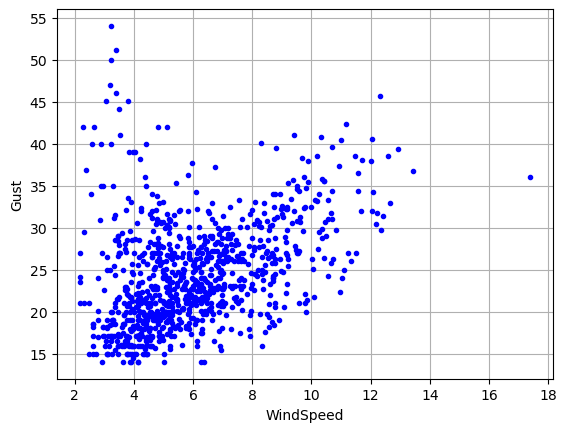

In [24]:
fig, ax = plt.subplots()
ax.plot(df['WindSpeed'], df['Gust'], '.', color = 'b')
ax.grid(True)
ax.set_ylabel(r'Gust')
ax.set_xlabel(r'WindSpeed')
plt.show()

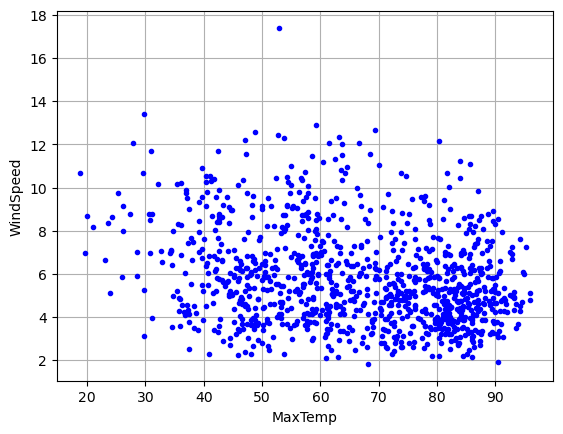

In [132]:
fig, ax = plt.subplots()
ax.plot(df['MaxTemp'], df['WindSpeed'], '.', color = 'b')
ax.grid(True)
ax.set_ylabel(r'WindSpeed')
ax.set_xlabel(r'MaxTemp')
plt.show()

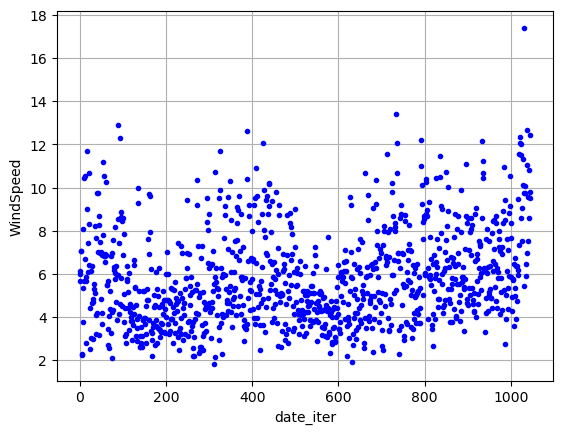

In [214]:
fig, ax = plt.subplots()
ax.plot(df['date_iter'], df['WindSpeed'], '.', color = 'b')
ax.grid(True)
ax.set_ylabel(r'WindSpeed')
ax.set_xlabel(r'date_iter')
plt.show()

A grid plot demonnstrates some of the colinearity present.

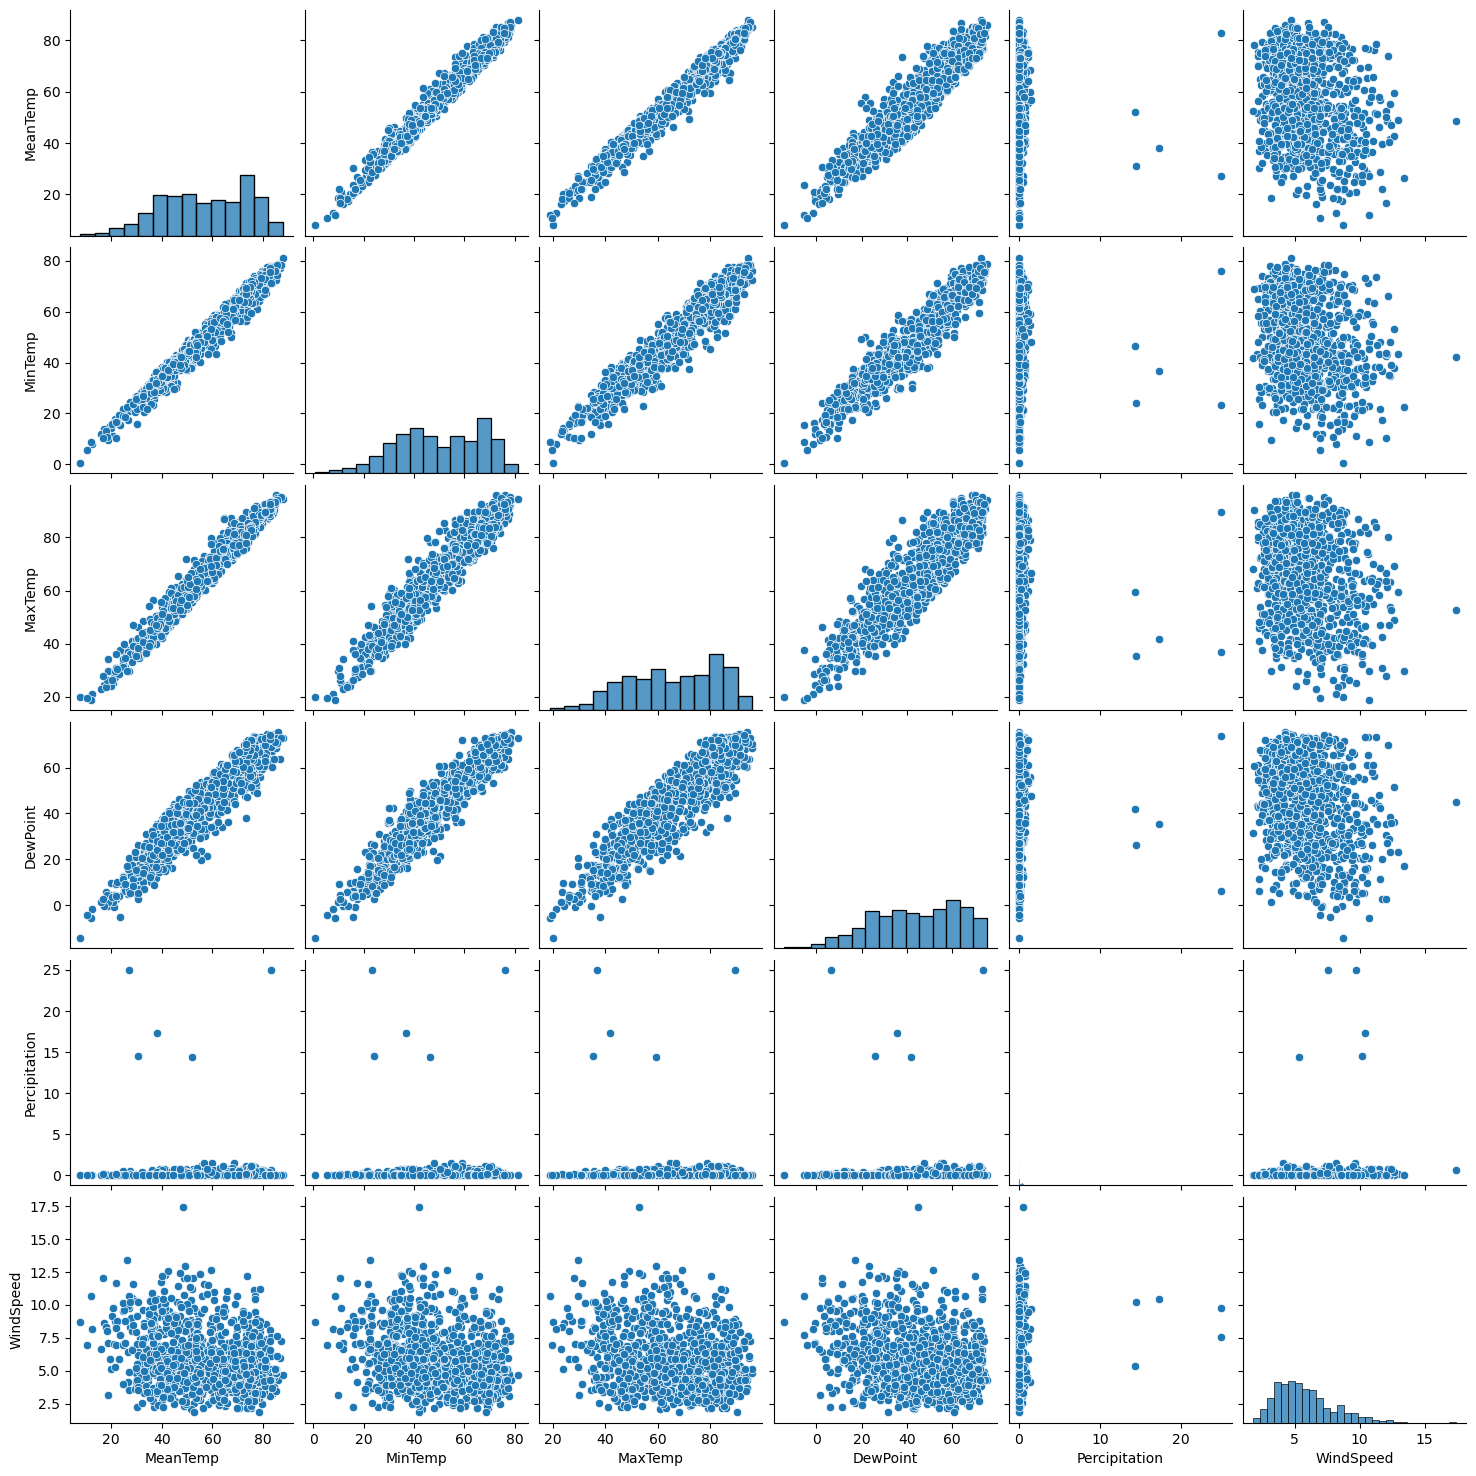

In [25]:
sns.pairplot(df.iloc[:,:7])

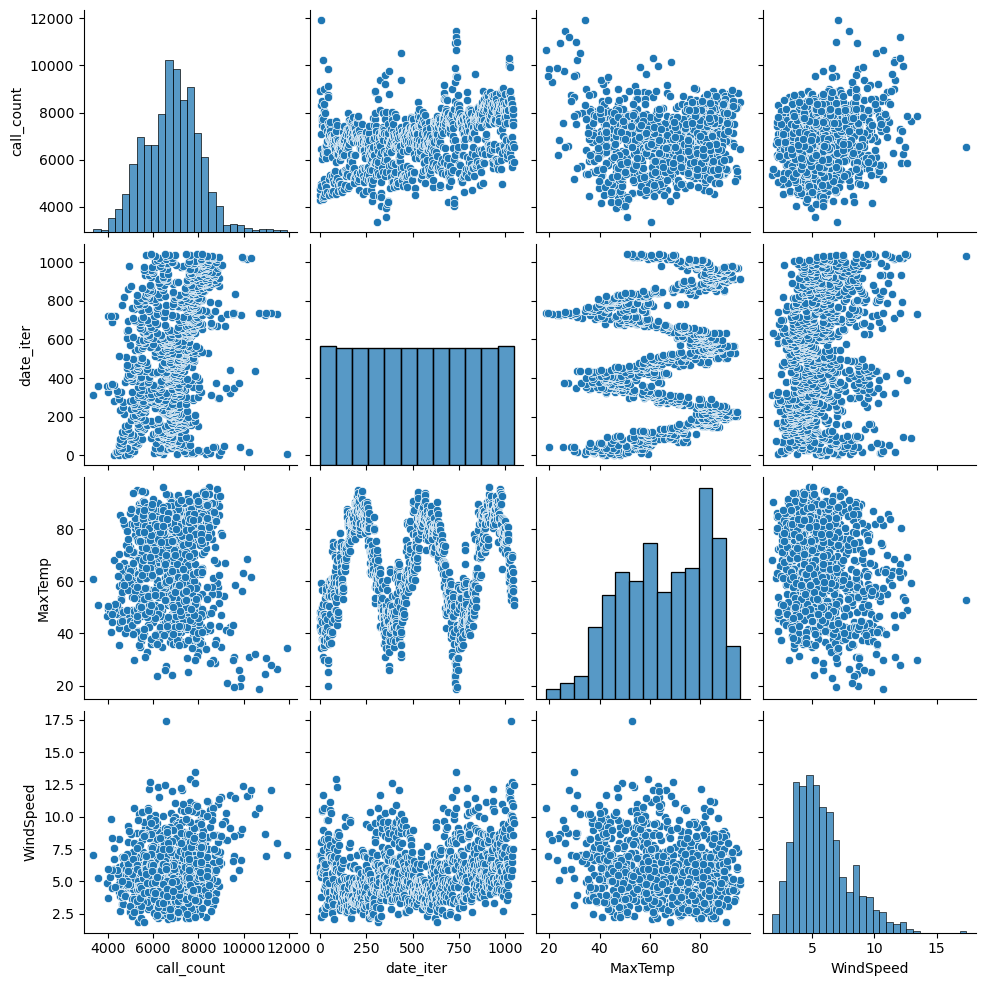

In [26]:
sns.pairplot(df.loc[:,['call_count', 'date_iter', 'MaxTemp', 'WindSpeed'] ])

# Try a very basic linear regression. 

Date_iter and MaxTemp as inputs, output is call_count.

In [27]:
x = df.loc[:,['date_iter', 'MaxTemp']].to_numpy()

In [28]:
x

array([[0.0000e+00, 4.8080e+01],
       [1.0000e+00, 4.1920e+01],
       [2.0000e+00, 4.5920e+01],
       ...,
       [1.0430e+03, 5.6325e+01],
       [1.0440e+03, 5.2775e+01],
       [1.0450e+03, 5.1050e+01]])

In [29]:
y = df['call_count'].to_numpy()

In [30]:
y

array([4260., 4505., 4749., ..., 7468., 6524., 5883.])

In [31]:
model = LinearRegression().fit(x, y)

In [32]:
r_sq = model.score(x, y)
print(f"R^2: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"coefficients: {model.coef_}")

R^2: 0.12197667118246125
intercept: 6463.077258928059
coefficients: [ 1.40336763 -5.52589544]


The R^2 value here is quite low since this model isn't doing a great job fitting the data. It's only a bit better than not including temerature.

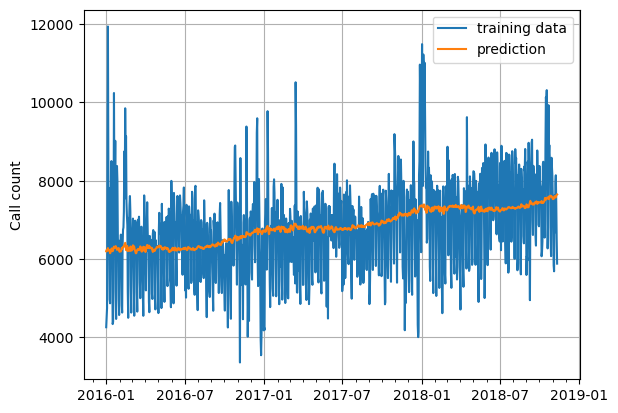

In [33]:
fig, ax = plt.subplots()
# common to all three:
ax.plot('Date', 'call_count', data=df, label = 'training data')
ax.plot(df['Date'], model.predict(x), label = 'prediction')
# ax.plot(df['Date'], df['date_iter']*model.coef_[0] + df['MeanTemp']*model.coef_[1] + model.intercept_)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

ax.grid(True)
ax.set_ylabel(r'Call count')
# ax.set_title('Calls per day', fontsize='medium')
ax.legend()
plt.show()

### Polynomial Regression

Try a slightly more complicated model. Still using date_iter and MeanTemp, but now using polynomial terms with degree=2.

In [34]:
from sklearn.preprocessing import PolynomialFeatures

In [35]:
transformer = PolynomialFeatures(degree=2, include_bias=False)
transformer.fit(x)
x_ = transformer.transform(x)
# x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)

In [36]:
x_

array([[0.00000000e+00, 4.80800000e+01, 0.00000000e+00, 0.00000000e+00,
        2.31168640e+03],
       [1.00000000e+00, 4.19200000e+01, 1.00000000e+00, 4.19200000e+01,
        1.75728640e+03],
       [2.00000000e+00, 4.59200000e+01, 4.00000000e+00, 9.18400000e+01,
        2.10864640e+03],
       ...,
       [1.04300000e+03, 5.63250000e+01, 1.08784900e+06, 5.87469750e+04,
        3.17250563e+03],
       [1.04400000e+03, 5.27750000e+01, 1.08993600e+06, 5.50971000e+04,
        2.78520062e+03],
       [1.04500000e+03, 5.10500000e+01, 1.09202500e+06, 5.33472500e+04,
        2.60610250e+03]])

Parameters of x_: [date_iter, MaxTemp, date_iter^2, date_iter*MaxTemp, MaxTemp^2]

In [37]:
model = LinearRegression().fit(x_, y)

In [38]:
r_sq = model.score(x_, y)
print(f"R^2: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"coefficients: {model.coef_}")

R^2: 0.19959226411608655
intercept: 10444.763096241357
coefficients: [-6.12048397e-01 -1.29177449e+02  1.87785483e-03  3.31441191e-05
  9.76925462e-01]


In [39]:
y_pred = model.predict(x_)

In [40]:
y_pred

array([6492.25663761, 6745.7734681 , 6571.7114409 , ..., 7674.54792974,
       7757.94582149, 7809.06419615])

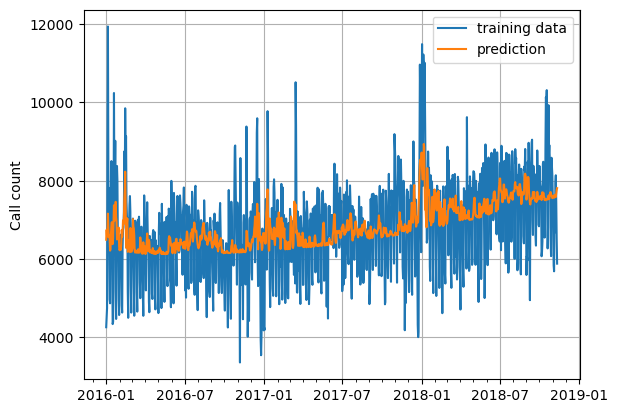

In [41]:
fig, ax = plt.subplots()
# common to all three:
# ax.plot('Date', 'call_count', data=df)
ax.plot('Date', 'call_count', data=df, label = 'training data')
ax.plot(df['Date'], y_pred, label = 'prediction')
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

ax.grid(True)
ax.set_ylabel(r'Call count')
# ax.set_title('Calls per day', fontsize='medium')
ax.legend()
plt.show()

This polynomial model, which includes temperature and time up to degree 2, does seem to caputure some of the large peaks in 311 calls.

### Modeling a bit more rigorously.
Split the dataset into training, cross validation, and test sets

In [42]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (627, 2)
the shape of the training set (target) is: (627,)

the shape of the cross validation set (input) is: (209, 2)
the shape of the cross validation set (target) is: (209,)

the shape of the test set (input) is: (210, 2)
the shape of the test set (target) is: (210,)


Run Feature Scaling

In [43]:
# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_scaled = scaler_linear.fit_transform(x_train)

print(f"Computed mean of the training set: {scaler_linear.mean_.squeeze()}")
print(f"Computed standard deviation of the training set: {scaler_linear.scale_.squeeze():}")

Computed mean of the training set: [524.51834131  66.20045113]
Computed standard deviation of the training set: [295.09337462  17.23457433]


Run standard linear regression on test set.

In [44]:
# Initialize the class
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train_scaled, y_train )

LinearRegression()

In [45]:
# Feed the scaled training set and get the predictions
yhat = linear_model.predict(X_train_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"training MSE (using sklearn function): {mean_squared_error(y_train, yhat) / 2}")

training MSE (using sklearn function): 643076.5588471863


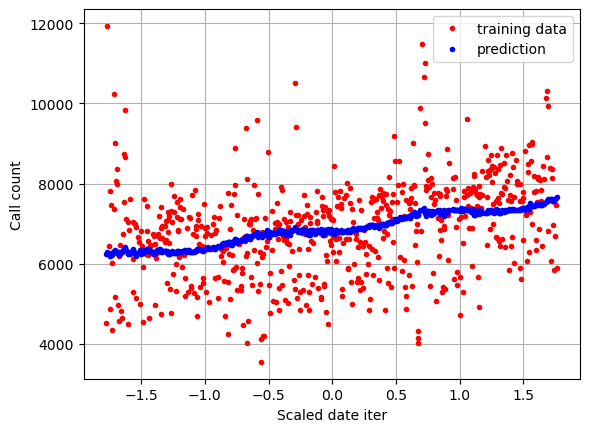

In [46]:
fig, ax = plt.subplots()
ax.plot(X_train_scaled[:,0], y_train, '.', color = 'r', label = 'training data')
ax.plot(X_train_scaled[:,0], yhat, '.', color = 'b', label = 'prediction')
ax.grid(True)
ax.set_ylabel(r'Call count')
ax.set_xlabel(r'Scaled date iter')
ax.legend()
plt.show()

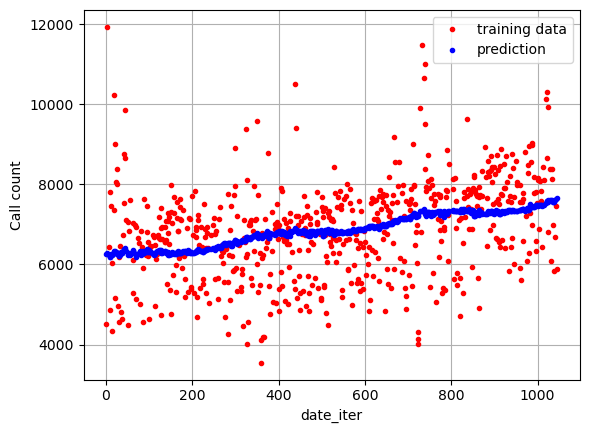

In [47]:
# Inverse transform to get x-axis to be date_iter again.
fig, ax = plt.subplots()
ax.plot(scaler_linear.inverse_transform(X_train_scaled)[:,0], y_train, '.', color = 'r', label = 'training data')
ax.plot(scaler_linear.inverse_transform(X_train_scaled)[:,0], yhat, '.', color = 'b', label = 'prediction')
ax.grid(True)
ax.set_ylabel(r'Call count')
ax.set_xlabel(r'date_iter')
ax.legend()
plt.show()

In [48]:
# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_scaled = scaler_linear.transform(x_cv)

print(f"Mean used to scale the CV set: {scaler_linear.mean_.squeeze():}")
print(f"Standard deviation used to scale the CV set: {scaler_linear.scale_.squeeze():}")

# Feed the scaled cross validation set
yhat = linear_model.predict(X_cv_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

Mean used to scale the CV set: [524.51834131  66.20045113]
Standard deviation used to scale the CV set: [295.09337462  17.23457433]
Cross validation MSE: 652052.366156318


Cross validation error is quite high, but almost the same as training error. This is not a good fit, but it isn't overfitting.

### Adding polynomial features

In [49]:
# Instantiate the class to make polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Compute the number of features and transform the training set
X_train_mapped = poly.fit_transform(x_train)

In [50]:
# Instantiate the class
scaler_poly = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)

In [51]:
# Initialize the class
model = LinearRegression()

# Train the model
model.fit(X_train_mapped_scaled, y_train )

# Compute the training MSE
yhat = model.predict(X_train_mapped_scaled)
print(f"Training MSE: {mean_squared_error(y_train, yhat) / 2}")

# Add the polynomial features to the cross validation set
X_cv_mapped = poly.transform(x_cv)

# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

# Compute the cross validation MSE
yhat_cv = model.predict(X_cv_mapped_scaled)
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat_cv) / 2}")

Training MSE: 574636.4381725662
Cross validation MSE: 584008.2974078375


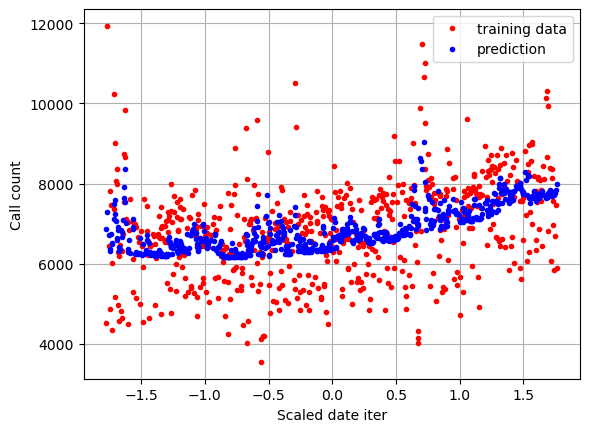

In [52]:
fig, ax = plt.subplots()
ax.plot(X_train_mapped_scaled[:,0], y_train, '.', color = 'r', label = 'training data')
ax.plot(X_train_mapped_scaled[:,0], yhat, '.', color = 'b', label = 'prediction')
ax.grid(True)
ax.set_ylabel(r'Call count')
ax.set_xlabel(r'Scaled date iter')
ax.legend()
plt.show()

This model isn't perfect, but it does appear to be capturing a few of the main  peaks present in the 311 call data.

### Try different polynomial degrees to see which performs best.

In [53]:
# Initialize lists containing the lists, models, and scalers
train_mses = []
cv_mses = []
models = []
scalers = []

# Loop over 10 times. Each adding one more degree of polynomial higher than the last.
for degree in range(1,11):
    
    # Add polynomial features to the training set
    poly = PolynomialFeatures(degree, include_bias=False)
    X_train_mapped = poly.fit_transform(x_train)
    
    # Scale the training set
    scaler_poly = StandardScaler()
    X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
    scalers.append(scaler_poly)
    
    # Create and train the model
    model = LinearRegression()
    model.fit(X_train_mapped_scaled, y_train )
    models.append(model)
    
    # Compute the training MSE
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    train_mses.append(train_mse)
    
    # Add polynomial features and scale the cross validation set
    poly = PolynomialFeatures(degree, include_bias=False)
    X_cv_mapped = poly.fit_transform(x_cv)
    X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)
    
    # Compute the cross validation MSE
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    cv_mses.append(cv_mse)
    
# Plot the results
degrees=range(1,11)
# utils.plot_train_cv_mses(degrees, train_mses, cv_mses, title="degree of polynomial vs. train and CV MSEs")

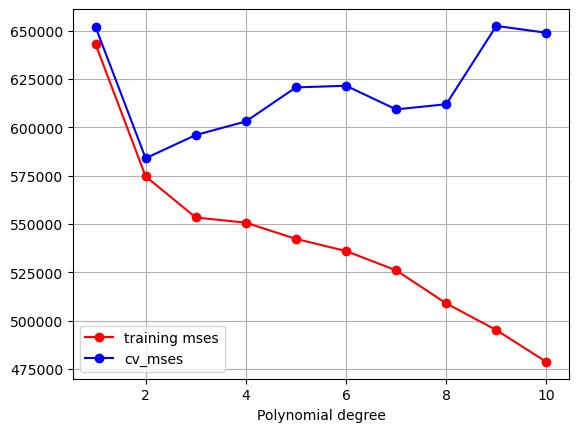

In [54]:
fig, ax = plt.subplots()
ax.plot(degrees, train_mses, 'o-', color = 'r', label = 'training mses')
ax.plot(degrees, cv_mses, 'o-', color = 'b', label = 'cv_mses')
ax.grid(True)
ax.set_xlabel(r'Polynomial degree')
ax.legend()
plt.show()

In [55]:
# Get the model with the lowest CV MSE (add 1 because list indices start at 0)
# This also corresponds to the degree of the polynomial added
degree = np.argmin(cv_mses) + 1
print(f"Lowest CV MSE is found in the model with degree={degree}")

Lowest CV MSE is found in the model with degree=2


In [56]:
# Add polynomial features to the test set
poly = PolynomialFeatures(degree, include_bias=False)
X_test_mapped = poly.fit_transform(x_test)

# Scale the test set
X_test_mapped_scaled = scalers[degree-1].transform(X_test_mapped)

# Compute the test MSE
yhat = models[degree-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Training MSE: {train_mses[degree-1]:.2f}")
print(f"Cross Validation MSE: {cv_mses[degree-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

Training MSE: 574636.44
Cross Validation MSE: 584008.30
Test MSE: 577332.10


The Test MSE error is high, so this isn't a great fit yet.
It isn't much higher than the training or CV sets though, so overfitting isn't an issue.

### Try Ridge to impose regularization.

In [57]:
# Instantiate the class to make polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Compute the number of features and transform the training set
X_train_mapped = poly.fit_transform(x_train)

In [58]:
# Instantiate the class
scaler_poly = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)

In [59]:
# Initialize the class
model = Ridge()

# Train the model
model.fit(X_train_mapped_scaled, y_train)

# Compute the training MSE
yhat = model.predict(X_train_mapped_scaled)
print(f"Training MSE: {mean_squared_error(y_train, yhat) / 2}")

# Add the polynomial features to the cross validation set
X_cv_mapped = poly.transform(x_cv)

# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

# Compute the cross validation MSE
yhat_cv = model.predict(X_cv_mapped_scaled)
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat_cv) / 2}")

Training MSE: 575688.1833593596
Cross validation MSE: 586416.5824730481


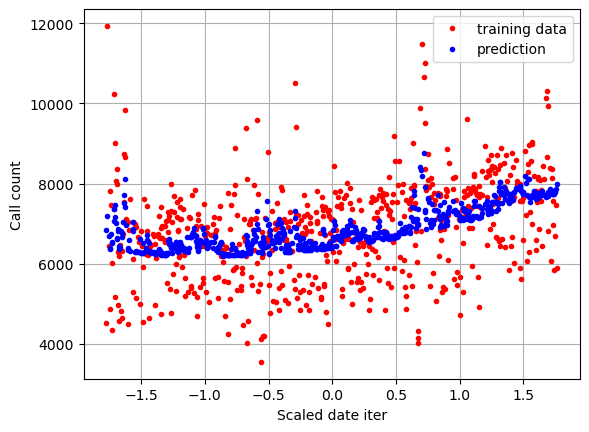

In [60]:
fig, ax = plt.subplots()
ax.plot(X_train_mapped_scaled[:,0], y_train, '.', color = 'r', label = 'training data')
ax.plot(X_train_mapped_scaled[:,0], yhat, '.', color = 'b', label = 'prediction')
ax.grid(True)
ax.set_ylabel(r'Call count')
ax.set_xlabel(r'Scaled date iter')
ax.legend()
plt.show()

In [61]:
print(f"intercept: {model.intercept_}")
print(f"coefficients: {model.coef_}")

intercept: 6861.9792663476865
coefficients: [ -310.3733462  -1953.39803058   762.13132673   -20.76146946
  1892.80127635]


Results (MSE and general fit) from Ridge model (which includes regularization) are very similar to model without regularization.

# Linear fits including more variables

In [62]:
df.head()

,Date,MeanTemp,MinTemp,MaxTemp,DewPoint,Percipitation,WindSpeed,MaxSustainedWind,Gust,SnowDepth,call_count,date_iter,weekday,MO,TU,WE,TH,FR,SA,SU
0,2016-01-01,41.28,38.38,48.08,25.800000,0.024,6.00,15.333333,24.666667,NaN,4260.0,0,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2016-01-02,36.82,33.42,41.92,18.466667,0.000,6.14,15.733333,22.433333,NaN,4505.0,1,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2016-01-03,38.80,33.18,45.92,21.333333,0.000,5.68,14.333333,23.066667,NaN,4749.0,2,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2016-01-04,32.54,21.62,42.64,15.066667,0.000,7.06,17.700000,27.366667,NaN,8900.0,3,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-01-05,18.90,11.82,34.32,-0.500000,0.000,7.08,20.400000,30.000000,NaN,11936.0,4,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# x = df.loc[:,['date_iter', 'MaxTemp', 'DewPoint', 'Percipitation', 'WindSpeed', 'Gust'
#               'MO', 'TU', 'WE', 'TH', 'FR', 'SA', 'SU']].to_numpy()

In [64]:
# Add Precipation, WindSpeed, and one-hot encoded weekdays.
# Skip DewPoint (too strongly colinear with MaxTemp) and TH to remove multicolinearity with other days.
# Skip Gust, which is similar to WindSpeed and throwing errors due to NaN values.
feature_vars = ['date_iter', 'MaxTemp', 'Percipitation', 'WindSpeed', 'MO','TU', 'WE', 'FR', 'SA', 'SU']
x = df.loc[:,feature_vars].to_numpy()

Split the dataset into training, cross validation, and test sets

In [65]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (627, 10)
the shape of the training set (target) is: (627,)

the shape of the cross validation set (input) is: (209, 10)
the shape of the cross validation set (target) is: (209,)

the shape of the test set (input) is: (210, 10)
the shape of the test set (target) is: (210,)


Run Feature Scaling

In [66]:
# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_scaled = scaler_linear.fit_transform(x_train)

print(f"Computed mean of the training set: {scaler_linear.mean_.squeeze()}")
print(f"Computed standard deviation of the training set: {scaler_linear.scale_.squeeze():}")

Computed mean of the training set: [5.24518341e+02 6.62004511e+01 1.29779145e-01 5.74975203e+00
 1.38755981e-01 1.53110048e-01 1.32376396e-01 1.65869219e-01
 1.49920255e-01 1.27591707e-01]
Computed standard deviation of the training set: [295.09337462  17.23457433   0.83084681   2.21171274   0.34569171
   0.36009354   0.33889952   0.3719632    0.35699324   0.33363462]


Run standard linear regression on test set.

In [67]:
# Initialize the class
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train_scaled, y_train )

LinearRegression()

In [68]:
# Feed the scaled training set and get the predictions
yhat = linear_model.predict(X_train_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"training MSE (using sklearn function): {mean_squared_error(y_train, yhat) / 2}")

training MSE (using sklearn function): 344041.0811627009


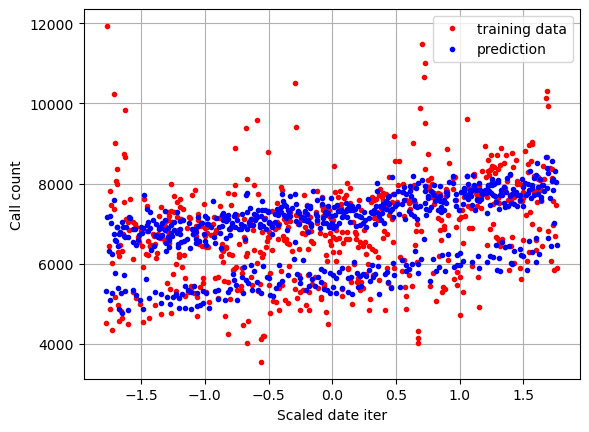

In [69]:
fig, ax = plt.subplots()
ax.plot(X_train_scaled[:,0], y_train, '.', color = 'r', label = 'training data')
ax.plot(X_train_scaled[:,0], yhat, '.', color = 'b', label = 'prediction')
ax.grid(True)
ax.set_ylabel(r'Call count')
ax.set_xlabel(r'Scaled date iter')
ax.legend()
plt.show()

In [70]:
print(f"intercept: {linear_model.intercept_}")
print(f"coefficients: {linear_model.coef_}")

intercept: 6861.979266347687
coefficients: [ 339.04306334  -34.24515383  -80.49273823  197.23509105   48.10302162
  120.7547336    60.9400993   -69.92852876 -498.7898827  -577.86780022]


In [71]:
coeff_df = pd.DataFrame([linear_model.coef_], columns =feature_vars)
coeff_df

,date_iter,MaxTemp,Percipitation,WindSpeed,MO,TU,WE,FR,SA,SU
0,339.043063,-34.245154,-80.492738,197.235091,48.103022,120.754734,60.940099,-69.928529,-498.789883,-577.8678


In [72]:
# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_scaled = scaler_linear.transform(x_cv)

print(f"Mean used to scale the CV set: {scaler_linear.mean_.squeeze():}")
print(f"Standard deviation used to scale the CV set: {scaler_linear.scale_.squeeze():}")

# Feed the scaled cross validation set
yhat = linear_model.predict(X_cv_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

Mean used to scale the CV set: [5.24518341e+02 6.62004511e+01 1.29779145e-01 5.74975203e+00
 1.38755981e-01 1.53110048e-01 1.32376396e-01 1.65869219e-01
 1.49920255e-01 1.27591707e-01]
Standard deviation used to scale the CV set: [295.09337462  17.23457433   0.83084681   2.21171274   0.34569171
   0.36009354   0.33889952   0.3719632    0.35699324   0.33363462]
Cross validation MSE: 326236.5046344697


Training and CV MSE are both similar values. Not overfitting.

Adding polynomial features.

In [73]:
# Instantiate the class to make polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Compute the number of features and transform the training set
X_train_mapped = poly.fit_transform(x_train)

In [74]:
# Instantiate the class
scaler_poly = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)

In [75]:
# Initialize the class
model = LinearRegression()

# Train the model
model.fit(X_train_mapped_scaled, y_train )

# Compute the training MSE
yhat = model.predict(X_train_mapped_scaled)
print(f"Training MSE: {mean_squared_error(y_train, yhat) / 2}")

# Add the polynomial features to the cross validation set
X_cv_mapped = poly.transform(x_cv)

# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

# Compute the cross validation MSE
yhat_cv = model.predict(X_cv_mapped_scaled)
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat_cv) / 2}")

Training MSE: 238439.8492941978
Cross validation MSE: 5287098.064735044


This cross validation error is an order of magnitude larger than the training error. Probably overfitting heavily.

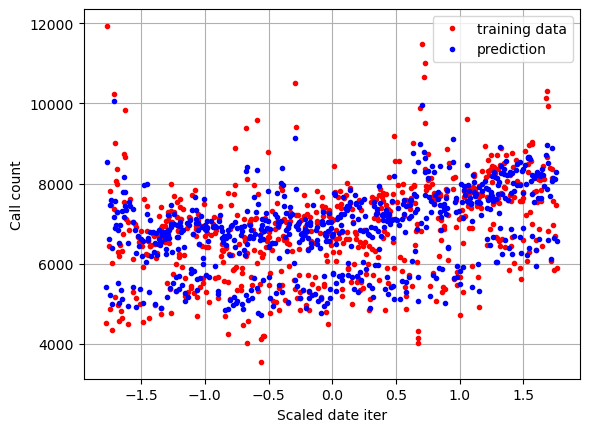

In [76]:
fig, ax = plt.subplots()
ax.plot(X_train_mapped_scaled[:,0], y_train, '.', color = 'r', label = 'training data')
ax.plot(X_train_mapped_scaled[:,0], yhat, '.', color = 'b', label = 'prediction')
ax.grid(True)
ax.set_ylabel(r'Call count')
ax.set_xlabel(r'Scaled date iter')
ax.legend()
plt.show()

In [77]:
# print(f"intercept: {model.intercept_}")
# print(f"coefficients: {model.coef_}")

### Try different polynomial degrees to see which performs best.

In [78]:
# Initialize lists containing the lists, models, and scalers
train_mses = []
cv_mses = []
models = []
scalers = []

# Loop over 10 times. Each adding one more degree of polynomial higher than the last.
for degree in range(1,3):
    
    # Add polynomial features to the training set
    poly = PolynomialFeatures(degree, include_bias=False)
    X_train_mapped = poly.fit_transform(x_train)
    
    # Scale the training set
    scaler_poly = StandardScaler()
    X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
    scalers.append(scaler_poly)
    
    # Create and train the model
    model = Ridge()
    model.fit(X_train_mapped_scaled, y_train )
    models.append(model)
    
    # Compute the training MSE
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    train_mses.append(train_mse)
    
    # Add polynomial features and scale the cross validation set
    poly = PolynomialFeatures(degree, include_bias=False)
    X_cv_mapped = poly.fit_transform(x_cv)
    X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)
    
    # Compute the cross validation MSE
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    cv_mses.append(cv_mse)
    
# Plot the results
degrees=range(1,3)
# utils.plot_train_cv_mses(degrees, train_mses, cv_mses, title="degree of polynomial vs. train and CV MSEs")

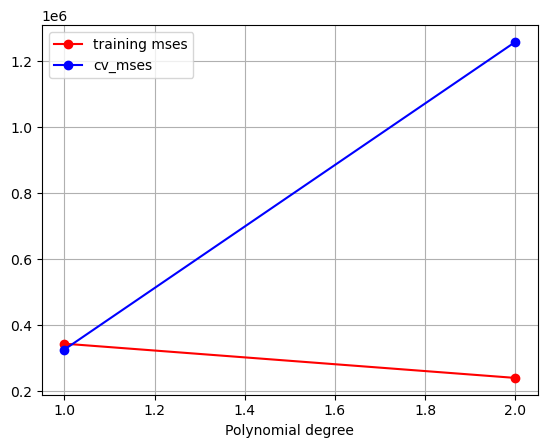

In [79]:
fig, ax = plt.subplots()
ax.plot(degrees, train_mses, 'o-', color = 'r', label = 'training mses')
ax.plot(degrees, cv_mses, 'o-', color = 'b', label = 'cv_mses')
ax.grid(True)
ax.set_xlabel(r'Polynomial degree')
ax.legend()
plt.show()

The CV MSE is much higher than the training MSE for polynomial degree>1. This confirms that using the standard sklearn PolynomialFeatures.fit_transform with Linear Regression overfits the data for degree>1.

Could include fewer polynomial features or potentially adjust regularization.

### Adding only some polynomial terms

I previously saw that degree=2 polynomial terms in MaxTemp and date_iter were helpful and didn't lead to overfitting. I can add a few polynomial terms without adding the mass of terms which comes from applying PolynomialFeatures to the whole set of columns.


In [80]:
# Add columns for MeanTemp**2 and date_iter**2
df.loc[:,'MaxTemp**2'] = df.loc[:, 'MaxTemp']**2
df.loc[:,'date_iter**2'] = df.loc[:, 'date_iter']**2

In [81]:
df.head()

,Date,MeanTemp,MinTemp,MaxTemp,DewPoint,Percipitation,WindSpeed,MaxSustainedWind,Gust,SnowDepth,...,weekday,MO,TU,WE,TH,FR,SA,SU,MaxTemp**2,date_iter**2
0,2016-01-01,41.28,38.38,48.08,25.800000,0.024,6.00,15.333333,24.666667,NaN,...,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2311.6864,0
1,2016-01-02,36.82,33.42,41.92,18.466667,0.000,6.14,15.733333,22.433333,NaN,...,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1757.2864,1
2,2016-01-03,38.80,33.18,45.92,21.333333,0.000,5.68,14.333333,23.066667,NaN,...,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2108.6464,4
3,2016-01-04,32.54,21.62,42.64,15.066667,0.000,7.06,17.700000,27.366667,NaN,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1818.1696,9
4,2016-01-05,18.90,11.82,34.32,-0.500000,0.000,7.08,20.400000,30.000000,NaN,...,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1177.8624,16


In [82]:
# Add Precipation, WindSpeed, and one-hot encoded weekdays.
# Skip DewPoint (too strongly colinear with MaxTemp) and TH to remove multicolinearity with other days.
# Skip Gust, which is similar to WindSpeed and throwing errors due to NaN values.
feature_vars = ['date_iter', 'date_iter**2', 'MaxTemp', 'MaxTemp**2', 
                'Percipitation', 'WindSpeed', 'MO','TU', 'WE', 'FR', 'SA', 'SU']
x = df.loc[:,feature_vars].to_numpy()

Split the dataset into training, cross validation, and test sets

In [83]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (627, 12)
the shape of the training set (target) is: (627,)

the shape of the cross validation set (input) is: (209, 12)
the shape of the cross validation set (target) is: (209,)

the shape of the test set (input) is: (210, 12)
the shape of the test set (target) is: (210,)


Run Feature Scaling

In [84]:
# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_scaled = scaler_linear.fit_transform(x_train)

print(f"Computed mean of the training set: {scaler_linear.mean_.squeeze()}")
print(f"Computed standard deviation of the training set: {scaler_linear.scale_.squeeze():}")

Computed mean of the training set: [5.24518341e+02 3.62199590e+05 6.62004511e+01 4.67953028e+03
 1.29779145e-01 5.74975203e+00 1.38755981e-01 1.53110048e-01
 1.32376396e-01 1.65869219e-01 1.49920255e-01 1.27591707e-01]
Computed standard deviation of the training set: [2.95093375e+02 3.19887026e+05 1.72345743e+01 2.21301998e+03
 8.30846810e-01 2.21171274e+00 3.45691710e-01 3.60093545e-01
 3.38899521e-01 3.71963198e-01 3.56993238e-01 3.33634625e-01]


Run standard linear regression on test set.

In [85]:
# Initialize the class
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train_scaled, y_train )

LinearRegression()

In [86]:
# Feed the scaled training set and get the predictions
yhat = linear_model.predict(X_train_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"training MSE (using sklearn function): {mean_squared_error(y_train, yhat) / 2}")

training MSE (using sklearn function): 269140.76507758873


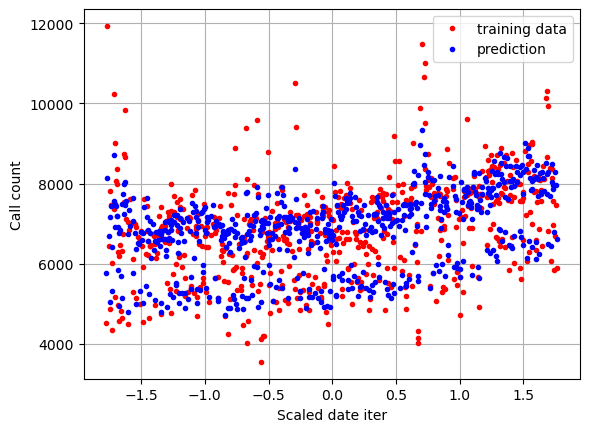

In [87]:
fig, ax = plt.subplots()
ax.plot(X_train_scaled[:,0], y_train, '.', color = 'r', label = 'training data')
ax.plot(X_train_scaled[:,0], yhat, '.', color = 'b', label = 'prediction')
ax.grid(True)
ax.set_ylabel(r'Call count')
ax.set_xlabel(r'Scaled date iter')
ax.legend()
plt.show()

In [88]:
print(f"intercept: {linear_model.intercept_}")
print(f"coefficients: {linear_model.coef_}")

intercept: 6861.9792663476865
coefficients: [ -192.20351361   561.74148512 -2654.42242973  2625.98827071
   -74.24508721   154.05940744    61.30224511   117.96345371
    60.96387897   -93.48666965  -533.80450541  -576.06008223]


In [89]:
coeff_df = pd.DataFrame([linear_model.coef_], columns =feature_vars)
coeff_df

,date_iter,date_iter**2,MaxTemp,MaxTemp**2,Percipitation,WindSpeed,MO,TU,WE,FR,SA,SU
0,-192.203514,561.741485,-2654.42243,2625.988271,-74.245087,154.059407,61.302245,117.963454,60.963879,-93.48667,-533.804505,-576.060082


In [90]:
# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_scaled = scaler_linear.transform(x_cv)

print(f"Mean used to scale the CV set: {scaler_linear.mean_.squeeze():}")
print(f"Standard deviation used to scale the CV set: {scaler_linear.scale_.squeeze():}")

# Feed the scaled cross validation set
yhat_cv = linear_model.predict(X_cv_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat_cv) / 2}")

Mean used to scale the CV set: [5.24518341e+02 3.62199590e+05 6.62004511e+01 4.67953028e+03
 1.29779145e-01 5.74975203e+00 1.38755981e-01 1.53110048e-01
 1.32376396e-01 1.65869219e-01 1.49920255e-01 1.27591707e-01]
Standard deviation used to scale the CV set: [2.95093375e+02 3.19887026e+05 1.72345743e+01 2.21301998e+03
 8.30846810e-01 2.21171274e+00 3.45691710e-01 3.60093545e-01
 3.38899521e-01 3.71963198e-01 3.56993238e-01 3.33634625e-01]
Cross validation MSE: 267590.1374292458


This inclusion of a few polynomial terms greatly reduces the CV error, which is now on par with the training error. This is also an improved error compared to the linear only model.

Visually, we can see that this model captures some of the spikes seen in the dataset.

In [91]:
# Check test MSE

# Scale the test set
X_test_scaled = scaler_linear.transform(x_test)

# Compute the test MSE
yhat_test = linear_model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, yhat_test) / 2

print(f"Test MSE: {test_mse:.2f}")

Test MSE: 237407.40


Test MSE is very similar to both training MSE and CV MSE. No evidence of overfitting.

### Try making predictions

Can use either historical data for the coming week or look at weather forecasts.

I want to include features for predicting that are included in the model.

    feature_vars = ['date_iter', 'date_iter**2', 'MaxTemp', 'MaxTemp**2', 
                'Percipitation', 'WindSpeed', 'MO','TU', 'WE', 'FR', 'SA', 'SU']
                
    x = df.loc[:,feature_vars].to_numpy()

In [92]:
# Get date iter for next week
pred_start_date = np.datetime64('2023-06-07')
date_iter_start = (pred_start_date - np.datetime64('2016-01-01'))/np.timedelta64(1, 'D')
fcast_date_iter = np.arange(date_iter_start, date_iter_start+7)

In [93]:
# create a dataframe for storing forcast data
fcast_df = pd.DataFrame(fcast_date_iter, columns = ['date_iter'])
fcast_df.loc[:, 'date_iter**2'] = fcast_df.loc[:,'date_iter']**2

Forcast weather info for NYC from https://www.wunderground.com/forecast/us/ny/new-york-city and weather.com for week starting from Wednesday 2023-06-07

In [94]:
fcast_df['MaxTemp'] = np.array([77, 72, 72, 79, 83, 73, 73], dtype='float64')
fcast_df.loc[:, 'MaxTemp**2'] = fcast_df.loc[:,'MaxTemp']**2
fcast_df['Percipitation'] = np.array([0, 0, 0.05, 0, 0.08, 0.5, 0.19], dtype='float64')
fcast_df['WindSpeed'] = np.array([8, 5, 4, 6, 8, 9, 8], dtype='float64')

In [95]:
# Add weekday columns
fcast_df['MO'] = np.array([0,0,0,0,0,1,0], dtype='float64')
fcast_df['TU'] = np.array([0,0,0,0,0,0,1], dtype='float64')
fcast_df['WE'] = np.array([1,0,0,0,0,0,0], dtype='float64')
fcast_df['FR'] = np.array([0,0,1,0,0,0,0], dtype='float64')
fcast_df['SA'] = np.array([0,0,0,1,0,0,0], dtype='float64')
fcast_df['SU'] = np.array([0,0,0,0,1,0,0], dtype='float64')
# Note: could do one-hot encoding easily using dates to clean this up slightly.
fcast_df['Date'] = np.arange(pred_start_date,7)

In [96]:
fcast_df

,date_iter,date_iter**2,MaxTemp,MaxTemp**2,Percipitation,WindSpeed,MO,TU,WE,FR,SA,SU,Date
0,2714.0,7365796.0,77.0,5929.0,0.00,8.0,0.0,0.0,1.0,0.0,0.0,0.0,2023-06-07
1,2715.0,7371225.0,72.0,5184.0,0.00,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-08
2,2716.0,7376656.0,72.0,5184.0,0.05,4.0,0.0,0.0,0.0,1.0,0.0,0.0,2023-06-09
3,2717.0,7382089.0,79.0,6241.0,0.00,6.0,0.0,0.0,0.0,0.0,1.0,0.0,2023-06-10
4,2718.0,7387524.0,83.0,6889.0,0.08,8.0,0.0,0.0,0.0,0.0,0.0,1.0,2023-06-11
5,2719.0,7392961.0,73.0,5329.0,0.50,9.0,1.0,0.0,0.0,0.0,0.0,0.0,2023-06-12
6,2720.0,7398400.0,73.0,5329.0,0.19,8.0,0.0,1.0,0.0,0.0,0.0,0.0,2023-06-13


In [97]:
# Compare to a section of training data. Everything looks reasonable.
df.loc[500:507, ['date_iter', 'date_iter**2', 'MaxTemp', 'MaxTemp**2', 
                'Percipitation', 'WindSpeed', 'MO','TU', 'WE', 'FR', 'SA', 'SU']]

,date_iter,date_iter**2,MaxTemp,MaxTemp**2,Percipitation,WindSpeed,MO,TU,WE,FR,SA,SU
500,500,250000,68.428571,4682.469388,0.018571,8.985714,1.0,0.0,0.0,0.0,0.0,0.0
501,501,251001,77.942857,6075.088980,0.005714,5.457143,0.0,1.0,0.0,0.0,0.0,0.0
502,502,252004,86.314286,7450.155918,0.011429,4.685714,0.0,0.0,1.0,0.0,0.0,0.0
503,503,253009,89.885714,8079.441633,0.021429,5.485714,0.0,0.0,0.0,0.0,0.0,0.0
504,504,254016,90.600000,8208.360000,0.001429,6.057143,0.0,0.0,0.0,1.0,0.0,0.0
505,505,255025,87.200000,7603.840000,0.010000,6.271429,0.0,0.0,0.0,0.0,1.0,0.0
506,506,256036,66.114286,4371.098776,0.018571,4.328571,0.0,0.0,0.0,0.0,0.0,1.0
507,507,257049,63.385714,4017.748776,0.041429,4.157143,1.0,0.0,0.0,0.0,0.0,0.0


In [98]:
# Convert the predicitction set to an array.
feature_vars = ['date_iter', 'date_iter**2', 'MaxTemp', 'MaxTemp**2', 
                'Percipitation', 'WindSpeed', 'MO','TU', 'WE', 'FR', 'SA', 'SU']
x_pred = fcast_df.loc[:,feature_vars].to_numpy()

# Scale the prediction set
X_pred_scaled = scaler_linear.transform(x_pred)

# Compute the predicted values
ypred = linear_model.predict(X_pred_scaled)


print(f"Predicted daily call counts: {np.round(ypred, decimals=2)}")

Predicted daily call counts: [18289.78 17795.87 17479.3  16564.15 16626.72 18260.75 18377.96]


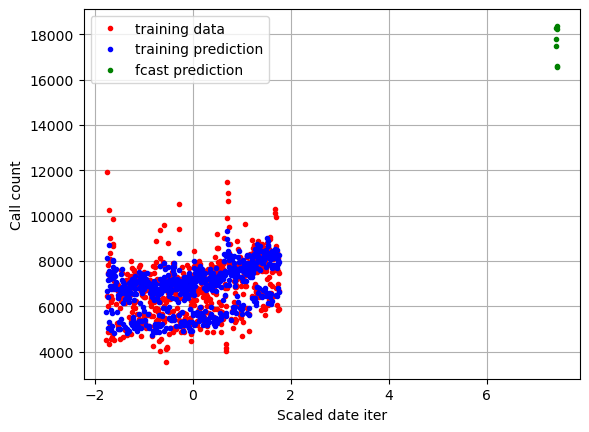

In [99]:
fig, ax = plt.subplots()
ax.plot(X_train_scaled[:,0], y_train, '.', color = 'r', label = 'training data')
ax.plot(X_train_scaled[:,0], yhat, '.', color = 'b', label = 'training prediction')
ax.plot(X_pred_scaled[:,0], ypred, '.', color = 'g', label = 'fcast prediction')
ax.grid(True)
ax.set_ylabel(r'Call count')
ax.set_xlabel(r'Scaled date iter')
ax.legend()
plt.show()

In [100]:
fcast_df['pred_call_count'] = np.round(ypred, decimals=2)

In [101]:
fcast_df

,date_iter,date_iter**2,MaxTemp,MaxTemp**2,Percipitation,WindSpeed,MO,TU,WE,FR,SA,SU,Date,pred_call_count
0,2714.0,7365796.0,77.0,5929.0,0.00,8.0,0.0,0.0,1.0,0.0,0.0,0.0,2023-06-07,18289.78
1,2715.0,7371225.0,72.0,5184.0,0.00,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-08,17795.87
2,2716.0,7376656.0,72.0,5184.0,0.05,4.0,0.0,0.0,0.0,1.0,0.0,0.0,2023-06-09,17479.30
3,2717.0,7382089.0,79.0,6241.0,0.00,6.0,0.0,0.0,0.0,0.0,1.0,0.0,2023-06-10,16564.15
4,2718.0,7387524.0,83.0,6889.0,0.08,8.0,0.0,0.0,0.0,0.0,0.0,1.0,2023-06-11,16626.72
5,2719.0,7392961.0,73.0,5329.0,0.50,9.0,1.0,0.0,0.0,0.0,0.0,0.0,2023-06-12,18260.75
6,2720.0,7398400.0,73.0,5329.0,0.19,8.0,0.0,1.0,0.0,0.0,0.0,0.0,2023-06-13,18377.96


This plot seems like the the model is likely overestimating the increase in calls over time. Maybe just use linear term in date_iter.

# Fitting linear model with some polynomial terms

Removing date_iter**2, which overpredicted increase in call numbers over time

### Adding only some polynomial terms

I previously saw that degree=2 polynomial terms in MaxTemp and date_iter were helpful and didn't lead to overfitting. I can add a few polynomial terms without adding the mass of terms which comes from applying PolynomialFeatures to the whole set of columns.


In [102]:
# Add columns for MeanTemp**2 and date_iter**2
df.loc[:,'MaxTemp**2'] = df.loc[:, 'MaxTemp']**2
df.loc[:,'WindSpeed**2'] = df.loc[:, 'WindSpeed']**2

In [103]:
df.head()

,Date,MeanTemp,MinTemp,MaxTemp,DewPoint,Percipitation,WindSpeed,MaxSustainedWind,Gust,SnowDepth,...,MO,TU,WE,TH,FR,SA,SU,MaxTemp**2,date_iter**2,WindSpeed**2
0,2016-01-01,41.28,38.38,48.08,25.800000,0.024,6.00,15.333333,24.666667,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2311.6864,0,36.0000
1,2016-01-02,36.82,33.42,41.92,18.466667,0.000,6.14,15.733333,22.433333,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1757.2864,1,37.6996
2,2016-01-03,38.80,33.18,45.92,21.333333,0.000,5.68,14.333333,23.066667,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2108.6464,4,32.2624
3,2016-01-04,32.54,21.62,42.64,15.066667,0.000,7.06,17.700000,27.366667,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1818.1696,9,49.8436
4,2016-01-05,18.90,11.82,34.32,-0.500000,0.000,7.08,20.400000,30.000000,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1177.8624,16,50.1264


In [104]:
# Add Precipation, WindSpeed, and one-hot encoded weekdays.
# Skip DewPoint (too strongly colinear with MaxTemp) and TH to remove multicolinearity with other days.
# Skip Gust, which is similar to WindSpeed and throwing errors due to NaN values.
feature_vars = ['date_iter', 'MaxTemp', 'MaxTemp**2', 
                'Percipitation', 'WindSpeed', 'WindSpeed**2', 'MO','TU', 'WE', 'FR', 'SA', 'SU']
x = df.loc[:,feature_vars].to_numpy()

Split the dataset into training, cross validation, and test sets

In [105]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (627, 12)
the shape of the training set (target) is: (627,)

the shape of the cross validation set (input) is: (209, 12)
the shape of the cross validation set (target) is: (209,)

the shape of the test set (input) is: (210, 12)
the shape of the test set (target) is: (210,)


Run Feature Scaling

In [106]:
# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_scaled = scaler_linear.fit_transform(x_train)

print(f"Computed mean of the training set: {scaler_linear.mean_.squeeze()}")
print(f"Computed standard deviation of the training set: {scaler_linear.scale_.squeeze():}")

Computed mean of the training set: [5.24518341e+02 6.62004511e+01 4.67953028e+03 1.29779145e-01
 5.74975203e+00 3.79513217e+01 1.38755981e-01 1.53110048e-01
 1.32376396e-01 1.65869219e-01 1.49920255e-01 1.27591707e-01]
Computed standard deviation of the training set: [2.95093375e+02 1.72345743e+01 2.21301998e+03 8.30846810e-01
 2.21171274e+00 3.01360623e+01 3.45691710e-01 3.60093545e-01
 3.38899521e-01 3.71963198e-01 3.56993238e-01 3.33634625e-01]


Run standard linear regression on test set.

In [107]:
# Initialize the class
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train_scaled, y_train )

LinearRegression()

In [108]:
# Feed the scaled training set and get the predictions
yhat = linear_model.predict(X_train_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"training MSE (using sklearn function): {mean_squared_error(y_train, yhat) / 2}")

training MSE (using sklearn function): 272500.14657194185


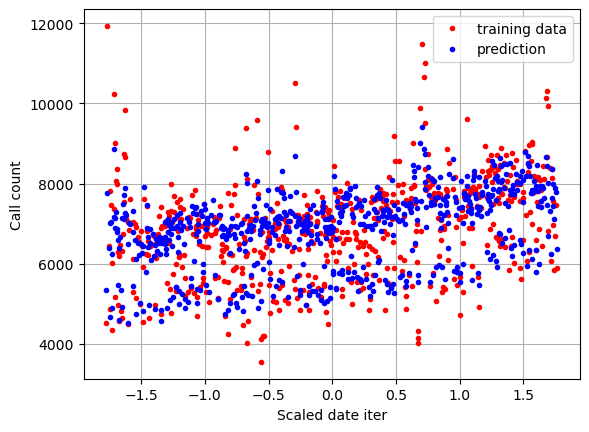

In [109]:
fig, ax = plt.subplots()
ax.plot(X_train_scaled[:,0], y_train, '.', color = 'r', label = 'training data')
ax.plot(X_train_scaled[:,0], yhat, '.', color = 'b', label = 'prediction')
ax.grid(True)
ax.set_ylabel(r'Call count')
ax.set_xlabel(r'Scaled date iter')
ax.legend()
plt.show()

In [110]:
print(f"intercept: {linear_model.intercept_}")
print(f"coefficients: {linear_model.coef_}")

intercept: 6861.9792663476865
coefficients: [  353.82532931 -2763.54251614  2747.86853215   -85.30404944
  -347.92432894   542.41306807    60.68992934   129.13279719
    62.92349548   -77.73368328  -528.73273749  -572.56754189]


In [111]:
coeff_df = pd.DataFrame([linear_model.coef_], columns =feature_vars)
coeff_df

,date_iter,MaxTemp,MaxTemp**2,Percipitation,WindSpeed,WindSpeed**2,MO,TU,WE,FR,SA,SU
0,353.825329,-2763.542516,2747.868532,-85.304049,-347.924329,542.413068,60.689929,129.132797,62.923495,-77.733683,-528.732737,-572.567542


In [112]:
# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_scaled = scaler_linear.transform(x_cv)

print(f"Mean used to scale the CV set: {scaler_linear.mean_.squeeze():}")
print(f"Standard deviation used to scale the CV set: {scaler_linear.scale_.squeeze():}")

# Feed the scaled cross validation set
yhat_cv = linear_model.predict(X_cv_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat_cv) / 2}")

Mean used to scale the CV set: [5.24518341e+02 6.62004511e+01 4.67953028e+03 1.29779145e-01
 5.74975203e+00 3.79513217e+01 1.38755981e-01 1.53110048e-01
 1.32376396e-01 1.65869219e-01 1.49920255e-01 1.27591707e-01]
Standard deviation used to scale the CV set: [2.95093375e+02 1.72345743e+01 2.21301998e+03 8.30846810e-01
 2.21171274e+00 3.01360623e+01 3.45691710e-01 3.60093545e-01
 3.38899521e-01 3.71963198e-01 3.56993238e-01 3.33634625e-01]
Cross validation MSE: 281340.33649529336


This inclusion of a few polynomial terms greatly reduces the CV error, which is now on par with the training error. This is also an improved error compared to the linear only model.

Visually, we can see that this model captures some of the spikes seen in the dataset.

In [113]:
# Check test MSE

# Scale the test set
X_test_scaled = scaler_linear.transform(x_test)

# Compute the test MSE
yhat_test = linear_model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, yhat_test) / 2

print(f"Test MSE: {test_mse:.2f}")

Test MSE: 258056.89


Test MSE is very similar to both training MSE and CV MSE. No evidence of overfitting.

### Try making predictions

Can use either historical data for the coming week or look at weather forecasts.

I want to include features for predicting that are included in the model.

    feature_vars = ['date_iter', 'MaxTemp', 'MaxTemp**2', 
                'Percipitation', 'WindSpeed', 'WindSpeed**2', 'MO','TU', 'WE', 'FR', 'SA', 'SU']
                
    x = df.loc[:,feature_vars].to_numpy()

In [114]:
# Get date iter for next week
pred_start_date = np.datetime64('2023-06-07')
date_iter_start = (pred_start_date - np.datetime64('2016-01-01'))/np.timedelta64(1, 'D')
fcast_date_iter = np.arange(date_iter_start, date_iter_start+7)

In [115]:
# create a dataframe for storing forcast data
fcast_df = pd.DataFrame(fcast_date_iter, columns = ['date_iter'])

Forcast weather info for NYC from https://www.wunderground.com/forecast/us/ny/new-york-city and weather.com for week starting from Wednesday 2023-06-07

In [116]:
fcast_df['MaxTemp'] = np.array([77, 72, 72, 79, 83, 73, 73], dtype='float64')
fcast_df.loc[:, 'MaxTemp**2'] = fcast_df.loc[:,'MaxTemp']**2
fcast_df['Percipitation'] = np.array([0, 0, 0.05, 0, 0.08, 0.5, 0.19], dtype='float64')
fcast_df['WindSpeed'] = np.array([8, 5, 4, 6, 8, 9, 8], dtype='float64')
fcast_df.loc[:, 'WindSpeed**2'] = fcast_df.loc[:,'WindSpeed']**2

In [117]:
# Add weekday columns
fcast_df['MO'] = np.array([0,0,0,0,0,1,0], dtype='float64')
fcast_df['TU'] = np.array([0,0,0,0,0,0,1], dtype='float64')
fcast_df['WE'] = np.array([1,0,0,0,0,0,0], dtype='float64')
fcast_df['FR'] = np.array([0,0,1,0,0,0,0], dtype='float64')
fcast_df['SA'] = np.array([0,0,0,1,0,0,0], dtype='float64')
fcast_df['SU'] = np.array([0,0,0,0,1,0,0], dtype='float64')
# Note: could do one-hot encoding easily using dates to clean this up slightly.
fcast_df['Date'] = np.arange(pred_start_date,7)

In [118]:
fcast_df

,date_iter,MaxTemp,MaxTemp**2,Percipitation,WindSpeed,WindSpeed**2,MO,TU,WE,FR,SA,SU,Date
0,2714.0,77.0,5929.0,0.00,8.0,64.0,0.0,0.0,1.0,0.0,0.0,0.0,2023-06-07
1,2715.0,72.0,5184.0,0.00,5.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-08
2,2716.0,72.0,5184.0,0.05,4.0,16.0,0.0,0.0,0.0,1.0,0.0,0.0,2023-06-09
3,2717.0,79.0,6241.0,0.00,6.0,36.0,0.0,0.0,0.0,0.0,1.0,0.0,2023-06-10
4,2718.0,83.0,6889.0,0.08,8.0,64.0,0.0,0.0,0.0,0.0,0.0,1.0,2023-06-11
5,2719.0,73.0,5329.0,0.50,9.0,81.0,1.0,0.0,0.0,0.0,0.0,0.0,2023-06-12
6,2720.0,73.0,5329.0,0.19,8.0,64.0,0.0,1.0,0.0,0.0,0.0,0.0,2023-06-13


In [119]:
# Compare to a section of training data. Everything looks reasonable.
df.loc[500:507, ['date_iter', 'MaxTemp', 'MaxTemp**2', 
                'Percipitation', 'WindSpeed', 'WindSpeed**2', 'MO','TU', 'WE', 'FR', 'SA', 'SU']]

,date_iter,MaxTemp,MaxTemp**2,Percipitation,WindSpeed,WindSpeed**2,MO,TU,WE,FR,SA,SU
500,500,68.428571,4682.469388,0.018571,8.985714,80.743061,1.0,0.0,0.0,0.0,0.0,0.0
501,501,77.942857,6075.088980,0.005714,5.457143,29.780408,0.0,1.0,0.0,0.0,0.0,0.0
502,502,86.314286,7450.155918,0.011429,4.685714,21.955918,0.0,0.0,1.0,0.0,0.0,0.0
503,503,89.885714,8079.441633,0.021429,5.485714,30.093061,0.0,0.0,0.0,0.0,0.0,0.0
504,504,90.600000,8208.360000,0.001429,6.057143,36.688980,0.0,0.0,0.0,1.0,0.0,0.0
505,505,87.200000,7603.840000,0.010000,6.271429,39.330816,0.0,0.0,0.0,0.0,1.0,0.0
506,506,66.114286,4371.098776,0.018571,4.328571,18.736531,0.0,0.0,0.0,0.0,0.0,1.0
507,507,63.385714,4017.748776,0.041429,4.157143,17.281837,1.0,0.0,0.0,0.0,0.0,0.0


In [120]:
# Convert the predicitction set to an array.
feature_vars = ['date_iter', 'MaxTemp', 'MaxTemp**2', 
                'Percipitation', 'WindSpeed', 'WindSpeed**2', 'MO','TU', 'WE', 'FR', 'SA', 'SU']
x_pred = fcast_df.loc[:,feature_vars].to_numpy()

# Scale the prediction set
X_pred_scaled = scaler_linear.transform(x_pred)

# Compute the predicted values
ypred = linear_model.predict(X_pred_scaled)


print(f"Predicted daily call counts: {np.round(ypred, decimals=2)}")

Predicted daily call counts: [ 9992.66  9454.86  9237.26  8206.88  8317.35  9982.27 10049.67]


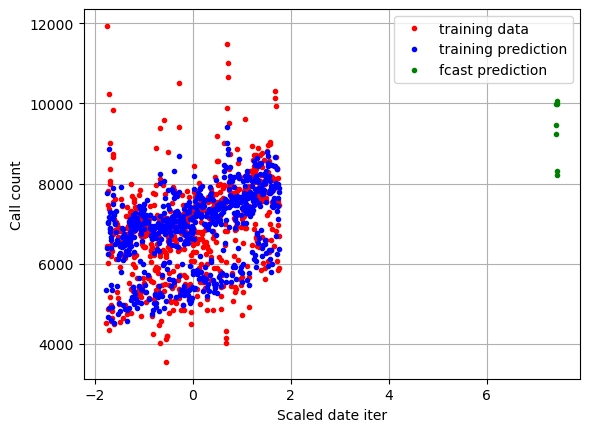

In [121]:
fig, ax = plt.subplots()
ax.plot(X_train_scaled[:,0], y_train, '.', color = 'r', label = 'training data')
ax.plot(X_train_scaled[:,0], yhat, '.', color = 'b', label = 'training prediction')
ax.plot(X_pred_scaled[:,0], ypred, '.', color = 'g', label = 'fcast prediction')
ax.grid(True)
ax.set_ylabel(r'Call count')
ax.set_xlabel(r'Scaled date iter')
ax.legend()
plt.show()

In [122]:
fcast_df['pred_call_count'] = np.round(ypred, decimals=2)

In [123]:
fcast_df

,date_iter,MaxTemp,MaxTemp**2,Percipitation,WindSpeed,WindSpeed**2,MO,TU,WE,FR,SA,SU,Date,pred_call_count
0,2714.0,77.0,5929.0,0.00,8.0,64.0,0.0,0.0,1.0,0.0,0.0,0.0,2023-06-07,9992.66
1,2715.0,72.0,5184.0,0.00,5.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-08,9454.86
2,2716.0,72.0,5184.0,0.05,4.0,16.0,0.0,0.0,0.0,1.0,0.0,0.0,2023-06-09,9237.26
3,2717.0,79.0,6241.0,0.00,6.0,36.0,0.0,0.0,0.0,0.0,1.0,0.0,2023-06-10,8206.88
4,2718.0,83.0,6889.0,0.08,8.0,64.0,0.0,0.0,0.0,0.0,0.0,1.0,2023-06-11,8317.35
5,2719.0,73.0,5329.0,0.50,9.0,81.0,1.0,0.0,0.0,0.0,0.0,0.0,2023-06-12,9982.27
6,2720.0,73.0,5329.0,0.19,8.0,64.0,0.0,1.0,0.0,0.0,0.0,0.0,2023-06-13,10049.67


In [124]:
fcast_df['pred_call_count'].mean()

9320.135714285714

This plot seems like the the model is likely overestimating the increase in calls over time. Maybe just use linear term in date_iter.

### Prediction interval

Determine the 95% prediction interval for this prediction.
(https://towardsdatascience.com/prediction-intervals-in-linear-regression-2ea14d419981)

In [125]:
def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    '''
    Get a prediction interval for a linear regression.
    
    INPUTS: 
        - Single prediction, 
        - y_test
        - All test set predictions,
        - Prediction interval threshold (default = .95) 
    OUTPUT: 
        - Prediction interval for single prediction
    '''
    
    #get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    #get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    #generate prediction interval lower and upper bound
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [126]:
get_prediction_interval(yhat_test[0], y_test, yhat_test)

(6213.741965997951, 7628.5541687784935, 9043.366371559036)

In [127]:
lower = np.zeros(len(fcast_df), dtype='float64')
upper = np.zeros(len(fcast_df), dtype='float64')
for i in range(len(fcast_df)):
    lower[i], prediction, upper[i] = get_prediction_interval(fcast_df.loc[i,'pred_call_count'], y_test, yhat_test)

In [128]:
fcast_df['lower'] = np.round(lower, 2)
fcast_df['upper'] = np.round(upper,2)

In [129]:
fcast_df

,date_iter,MaxTemp,MaxTemp**2,Percipitation,WindSpeed,WindSpeed**2,MO,TU,WE,FR,SA,SU,Date,pred_call_count,lower,upper
0,2714.0,77.0,5929.0,0.00,8.0,64.0,0.0,0.0,1.0,0.0,0.0,0.0,2023-06-07,9992.66,8577.85,11407.47
1,2715.0,72.0,5184.0,0.00,5.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-08,9454.86,8040.05,10869.67
2,2716.0,72.0,5184.0,0.05,4.0,16.0,0.0,0.0,0.0,1.0,0.0,0.0,2023-06-09,9237.26,7822.45,10652.07
3,2717.0,79.0,6241.0,0.00,6.0,36.0,0.0,0.0,0.0,0.0,1.0,0.0,2023-06-10,8206.88,6792.07,9621.69
4,2718.0,83.0,6889.0,0.08,8.0,64.0,0.0,0.0,0.0,0.0,0.0,1.0,2023-06-11,8317.35,6902.54,9732.16
5,2719.0,73.0,5329.0,0.50,9.0,81.0,1.0,0.0,0.0,0.0,0.0,0.0,2023-06-12,9982.27,8567.46,11397.08
6,2720.0,73.0,5329.0,0.19,8.0,64.0,0.0,1.0,0.0,0.0,0.0,0.0,2023-06-13,10049.67,8634.86,11464.48


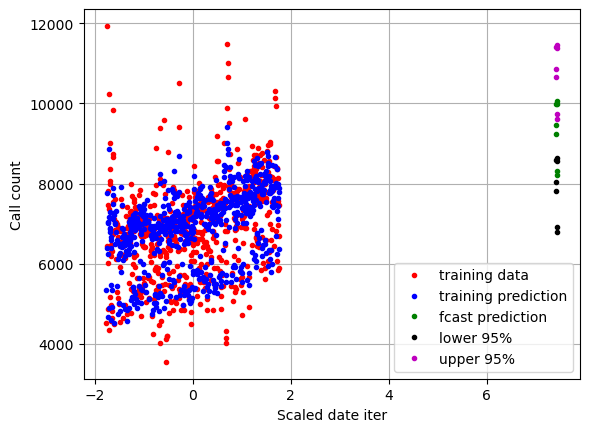

In [130]:
fig, ax = plt.subplots()
ax.plot(X_train_scaled[:,0], y_train, '.', color = 'r', label = 'training data')
ax.plot(X_train_scaled[:,0], yhat, '.', color = 'b', label = 'training prediction')
ax.plot(X_pred_scaled[:,0], ypred, '.', color = 'g', label = 'fcast prediction')
ax.plot(X_pred_scaled[:,0], fcast_df.loc[:,'lower'], '.', color = 'k', label = 'lower 95%')
ax.plot(X_pred_scaled[:,0], fcast_df.loc[:,'upper'], '.', color = 'm', label = 'upper 95%')
ax.grid(True)
ax.set_ylabel(r'Call count')
ax.set_xlabel(r'Scaled date iter')
ax.legend()
plt.show()

## Test: Understanding WindSpeed Coeff

I want to make sure I undertand the WindSpeed coefficients.

Linear: Positive coefficient for WindSpeed contributing to call_count

Polynomial: Negative coeff. for WindSpeed, positive coeff for WindSpeed**2

Start with simple linear model

In [133]:
feature_vars_lin = ['date_iter', 'WindSpeed']
feature_vars_poly = ['date_iter', 'WindSpeed', 'WindSpeed**2']
x = df.loc[:,feature_vars_lin].to_numpy()

In [134]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (627, 2)
the shape of the training set (target) is: (627,)

the shape of the cross validation set (input) is: (209, 2)
the shape of the cross validation set (target) is: (209,)

the shape of the test set (input) is: (210, 2)
the shape of the test set (target) is: (210,)


Run Feature Scaling

In [135]:
# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_scaled = scaler_linear.fit_transform(x_train)

print(f"Computed mean of the training set: {scaler_linear.mean_.squeeze()}")
print(f"Computed standard deviation of the training set: {scaler_linear.scale_.squeeze():}")

Computed mean of the training set: [524.51834131   5.74975203]
Computed standard deviation of the training set: [295.09337462   2.21171274]


Run standard linear regression on test set.

In [136]:
# Initialize the class
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train_scaled, y_train )

LinearRegression()

In [137]:
# Feed the scaled training set and get the predictions
yhat = linear_model.predict(X_train_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"training MSE (using sklearn function): {mean_squared_error(y_train, yhat) / 2}")

training MSE (using sklearn function): 629565.0292786098


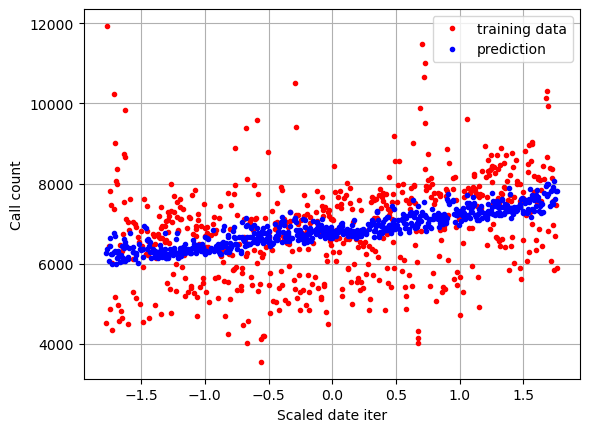

In [138]:
fig, ax = plt.subplots()
ax.plot(X_train_scaled[:,0], y_train, '.', color = 'r', label = 'training data')
ax.plot(X_train_scaled[:,0], yhat, '.', color = 'b', label = 'prediction')
ax.grid(True)
ax.set_ylabel(r'Call count')
ax.set_xlabel(r'Scaled date iter')
ax.legend()
plt.show()

In [139]:
print(f"intercept: {linear_model.intercept_}")
print(f"coefficients: {linear_model.coef_}")

intercept: 6861.979266347687
coefficients: [352.4859908  187.22307264]


In [141]:
coeff_df = pd.DataFrame([linear_model.coef_], columns =feature_vars_lin)
coeff_df

,date_iter,WindSpeed
0,352.485991,187.223073


#### Polynomial test model

In [203]:
feature_vars_lin = ['date_iter', 'WindSpeed']
feature_vars_poly = ['date_iter', 'WindSpeed', 'WindSpeed**2']
x = df.loc[:,feature_vars_poly].to_numpy()

In [204]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (627, 3)
the shape of the training set (target) is: (627,)

the shape of the cross validation set (input) is: (209, 3)
the shape of the cross validation set (target) is: (209,)

the shape of the test set (input) is: (210, 3)
the shape of the test set (target) is: (210,)


Run Feature Scaling

In [205]:
# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_scaled = scaler_linear.fit_transform(x_train)

print(f"Computed mean of the training set: {scaler_linear.mean_.squeeze()}")
print(f"Computed standard deviation of the training set: {scaler_linear.scale_.squeeze():}")

Computed mean of the training set: [524.51834131   5.74975203  37.95132167]
Computed standard deviation of the training set: [295.09337462   2.21171274  30.13606232]


Run standard linear regression on test set.

In [206]:
# Initialize the class
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train_scaled, y_train )

LinearRegression()

In [207]:
# Feed the scaled training set and get the predictions
yhat = linear_model.predict(X_train_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"training MSE (using sklearn function): {mean_squared_error(y_train, yhat) / 2}")

training MSE (using sklearn function): 622713.4441447005


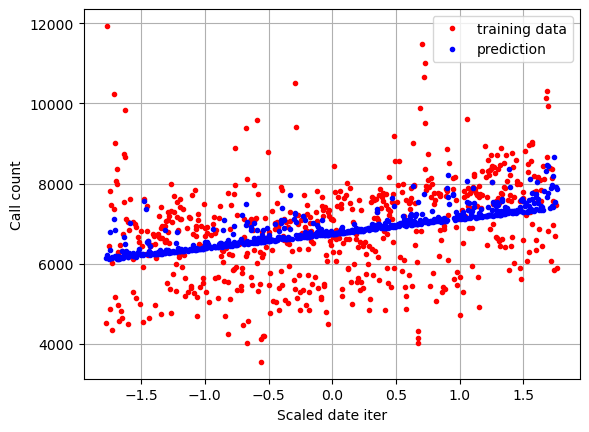

In [208]:
fig, ax = plt.subplots()
ax.plot(X_train_scaled[:,0], y_train, '.', color = 'r', label = 'training data')
ax.plot(X_train_scaled[:,0], yhat, '.', color = 'b', label = 'prediction')
ax.grid(True)
ax.set_ylabel(r'Call count')
ax.set_xlabel(r'Scaled date iter')
ax.legend()
plt.show()

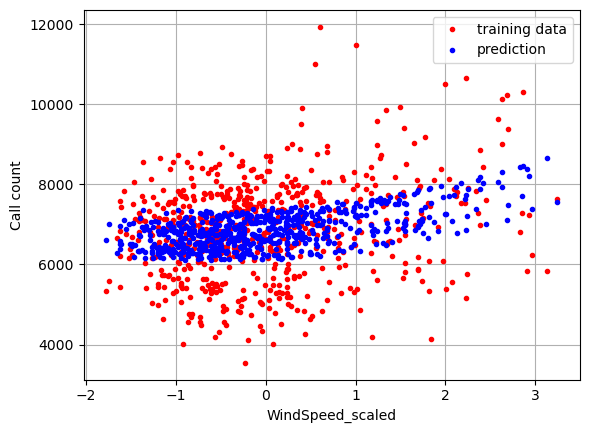

In [210]:
fig, ax = plt.subplots()
ax.plot(X_train_scaled[:,1], y_train, '.', color = 'r', label = 'training data')
ax.plot(X_train_scaled[:,1], yhat, '.', color = 'b', label = 'prediction')
ax.grid(True)
ax.set_ylabel(r'Call count')
ax.set_xlabel(r'WindSpeed_scaled')
ax.legend()
plt.show()

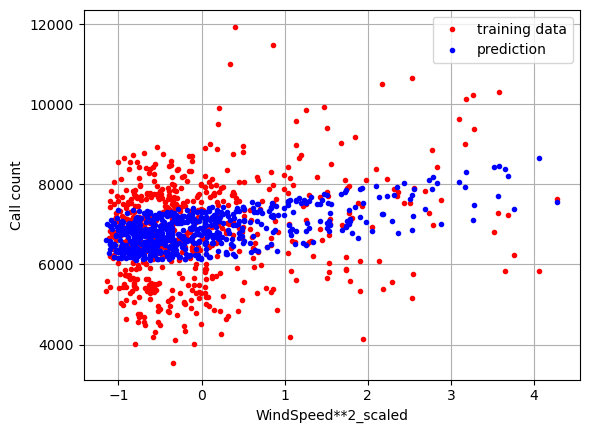

In [212]:
fig, ax = plt.subplots()
ax.plot(X_train_scaled[:,2], y_train, '.', color = 'r', label = 'training data')
ax.plot(X_train_scaled[:,2], yhat, '.', color = 'b', label = 'prediction')
ax.grid(True)
ax.set_ylabel(r'Call count')
ax.set_xlabel(r'WindSpeed**2_scaled')
ax.legend()
plt.show()

In [148]:
print(f"intercept: {linear_model.intercept_}")
print(f"coefficients: {linear_model.coef_}")

intercept: 6861.979266347687
coefficients: [ 364.97809572 -382.33118639  578.85530981]


In [149]:
coeff_df = pd.DataFrame([linear_model.coef_], columns =feature_vars_poly)
coeff_df

,date_iter,WindSpeed,WindSpeed**2
0,364.978096,-382.331186,578.85531


#### Just plotting call_count vs WindSpeed

In [174]:
# Make an array of call counts
y = df['call_count'].to_numpy()

In [175]:
x = df.loc[:,'WindSpeed'].to_numpy().reshape((-1,1))

In [176]:
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

coefficient of determination: 0.04865491190399995
intercept: 6139.766865198238
slope: [119.43616888]


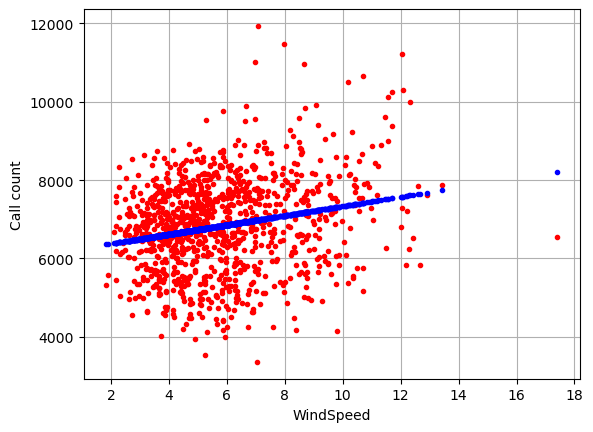

In [177]:
fig, ax = plt.subplots()
ax.plot(x[:,0], y, '.', color = 'r', label = 'training data')
ax.plot(x[:,0], model.predict(x), '.', color = 'b', label = 'linear')
ax.grid(True)
ax.set_xlabel(r'WindSpeed')
ax.set_ylabel(r'Call count')
plt.show()

In [191]:
x = df.loc[:,['WindSpeed', 'WindSpeed**2']].to_numpy()

In [192]:
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"coeff: {model.coef_}")

coefficient of determination: 0.049552295870675334
intercept: 6349.952157726019
coeff: [48.54935278  5.21377316]


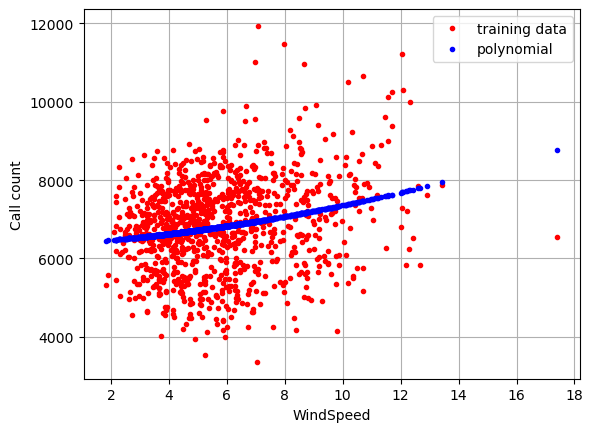

In [193]:
fig, ax = plt.subplots()
ax.plot(x[:,0], y, '.', color = 'r', label = 'training data')
ax.plot(x[:,0], model.predict(x), '.', color = 'b', label = 'polynomial')
ax.grid(True)
ax.set_xlabel(r'WindSpeed')
ax.set_ylabel(r'Call count')
ax.legend()
plt.show()

In [194]:
# Initialize the class for feature scaling
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_scaled = scaler_linear.fit_transform(x)

In [200]:
model = LinearRegression().fit(X_scaled, y)
r_sq = model.score(X_scaled, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"coeff: {model.coef_}")

coefficient of determination: 0.049552295870675334
intercept: 6832.445506692161
coeff: [107.50004775 161.01734788]


In [201]:
# Feed the scaled training set and get the predictions
yhat = model.predict(X_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"training MSE (using sklearn function): {mean_squared_error(y, yhat) / 2}")

training MSE (using sklearn function): 683114.7978920689


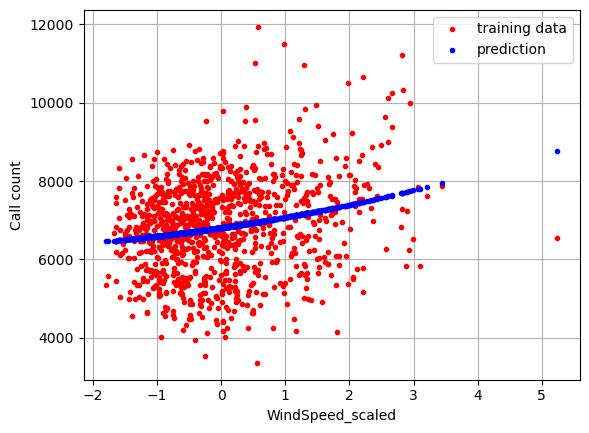

In [202]:
fig, ax = plt.subplots()
ax.plot(X_scaled[:,0], y, '.', color = 'r', label = 'training data')
ax.plot(X_scaled[:,0], yhat, '.', color = 'b', label = 'prediction')
ax.grid(True)
ax.set_xlabel(r'WindSpeed_scaled')
ax.set_ylabel(r'Call count')
ax.legend()
plt.show()

Here I have positive coefficients for both WindSpeed and WindSpeed**2 when date isn't included.

Is WindSpeed increasing with date?

In [216]:
x = df.loc[:,['date_iter']].to_numpy().reshape((-1,1))
y = df.loc[:,['WindSpeed']].to_numpy()

In [217]:
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

coefficient of determination: 0.055112366892991815
intercept: [4.90008425]
slope: [[0.00172151]]


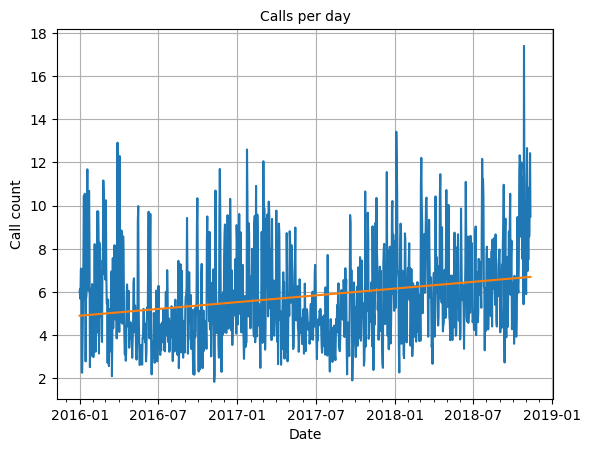

In [218]:
fig, ax = plt.subplots()
ax.plot('Date', 'WindSpeed', data=df)
ax.plot(df['Date'], model.predict(x))
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
# ax.set_xlabel(r'Days (since beginning of 2016)')
ax.set_xlabel(r'Date')
ax.set_ylabel(r'Call count')
ax.set_title('Calls per day', fontsize='medium')
plt.show()

This seems to be the source of my confusion. WindSpeed averages are changing over time. 